# Design CTP-11 mouse 1000 genome DNA-MERFISH library 

by Pu Zheng

2021.10.20


# Table of contents


> 0. [Minimum required packages and settings](#0)
>>
>> 0.1: [import required packages](#0.1)
>
> 1. [Extract region sequences](#1)

<a id='0.1'></a>
## 0.1 load required packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

20272


<a id='1'></a>
# 1 Extract region sequences

In [2]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain'

In [3]:
resolution = 0
flanking = 10000
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'mouse_genome_1000')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
# folder for fasta sequences
sequence_folder = os.path.join(library_folder, 'sequences')
if not os.path.exists(sequence_folder):
    print(f"create sequence folder: {sequence_folder}")
    os.makedirs(sequence_folder)
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')
if not os.path.exists(report_folder):
    print(f"create report folder: {report_folder}")
    os.makedirs(report_folder)
    
print(f"-- library_folder: {library_folder}")
print(f"-- sequence_folder: {sequence_folder}")
print(f"-- report_folder: {report_folder}")

-- library_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000
-- sequence_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences
-- report_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\reports


## 1.1 select regions

In [4]:
from tqdm.notebook import tqdm

In [104]:
# prepare sequence reader
reload(ia.library_tools.sequences)
seq_rd = ia.library_tools.sequences.sequence_reader(genome_folder)
seq_rd.load_sequences() # load genomic sequences

-- load sequence: 1, size=195471971
-- load sequence: 2, size=182113224
-- load sequence: 3, size=160039680
-- load sequence: 4, size=156508116
-- load sequence: 5, size=151834684
-- load sequence: 6, size=149736546
-- load sequence: 7, size=145441459
-- load sequence: 8, size=129401213
-- load sequence: 9, size=124595110
-- load sequence: 10, size=130694993
-- load sequence: 11, size=122082543
-- load sequence: 12, size=120129022
-- load sequence: 13, size=120421639
-- load sequence: 14, size=124902244
-- load sequence: 15, size=104043685
-- load sequence: 16, size=98207768
-- load sequence: 17, size=94987271
-- load sequence: 18, size=90702639
-- load sequence: 19, size=61431566
-- load sequence: MT, size=16299
-- load sequence: X, size=171031299
-- load sequence: Y, size=91744698
-- load sequence: JH584299.1, size=953012
-- load sequence: GL456233.1, size=336933
-- load sequence: JH584301.1, size=259875
-- load sequence: GL456211.1, size=241735
-- load sequence: GL456350.1, size=227

In [27]:
# calculate total length
min_chr_len = 1000000
chr_len_dict = {_name:len(_record) for _name, _record in seq_rd.ref_seq_dict.items() if len(_record) > min_chr_len}
total_len = sum(list(chr_len_dict.values()))
print(total_len)

2725521370


In [72]:
# calculate number of regions per chr
total_reg_num = 1100
chr_2_region_num = {_name: np.round(_len/total_len*total_reg_num).astype(np.int32) for _name, _len in chr_len_dict.items()}

genomic_resolution = np.round(total_len / total_reg_num, -5).astype(np.int32)
print(np.sum(list(chr_2_region_num.values())))
print(genomic_resolution)


1099
2500000


In [187]:
chr_2_region_num

{'1': 79,
 '2': 73,
 '3': 65,
 '4': 63,
 '5': 61,
 '6': 60,
 '7': 59,
 '8': 52,
 '9': 50,
 '10': 53,
 '11': 49,
 '12': 48,
 '13': 49,
 '14': 50,
 '15': 42,
 '16': 40,
 '17': 38,
 '18': 37,
 '19': 25,
 'X': 69,
 'Y': 37}

In [98]:
# for each chromosome, calculate region center
region_size=20000

chr_2_region_seq = {}

region_dicts = []


for _chr, _num in chr_2_region_num.items():
    _reg_center = np.array(np.arange(_num)*genomic_resolution + int(genomic_resolution/2), dtype=np.int32)
    _reg_starts = _reg_center - int(region_size/2)
    _reg_ends = _reg_center + int(region_size/2)
    _seqs = [seq_rd.ref_seq_dict[_chr][_s:_e] for _s,_e in zip(_reg_starts, _reg_ends)]
    chr_2_region_seq[_chr] = _seqs
    
    for _s,_e in zip(_reg_starts, _reg_ends):
        _reg_dict = {
            'Chr':_chr,
            'Start':_s,
            'End':_e,
            'Region':f"{_chr}:{_s}-{_e}",
            'Strand':'+',
        }
        region_dicts.append(_reg_dict)
    

In [105]:
seqs = seq_rd.find_sequence_for_region(region_dicts)

-- searching among 21 references
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a m

-- a match found in record: 15.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a match found in record: 16.
-- a mat

In [109]:
seq_rd.save_sequences(save_folder=sequence_folder)

-- saving sequences into folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_4.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_5.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_6.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_154.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_155.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_156.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_157.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_158.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_159.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_160.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequ

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_244.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_245.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_246.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_247.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_248.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_249.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_250.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequ

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_339.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_340.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_341.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_342.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_343.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_344.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_345.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequ

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_431.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_432.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_433.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_434.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_435.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_436.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_437.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequ

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_508.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_509.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_510.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_511.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_512.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_513.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_514.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequ

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_602.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_603.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_604.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_605.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_606.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_607.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_608.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequ

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_698.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_699.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_700.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_701.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_702.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_703.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_704.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequ

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_795.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_796.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_797.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_798.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_799.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_800.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_801.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequ

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_889.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_890.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_891.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_892.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_893.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_894.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_895.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequ

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_986.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_987.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_988.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_989.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_990.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_991.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_992.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequ

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1079.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1080.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1081.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1082.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1083.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1084.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1085.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_10

<a id='2'></a>
# 2. Design probe targeting sequences by probe_designer

run probe_designer, remeber to clear the memory usage because each table should take ~32GB

<a id='2.1'></a>
## 2.1 Construct count table with all the 17-mers in the genome

Only do this if you don't have pre-built 17-mer

However you can do almost the same thing for your own library during quality check

This library requires mm10 genome

In [110]:
overwrite_table = False

### construct map for whole genome

In [112]:
from ImageAnalysis3 import library_tools

In [126]:
reload(library_tools.design)
 
genome_table_file = os.path.join(reference_folder, 'GRCm38_genome_17w.npy')

if not os.path.exists(genome_table_file) or overwrite_table:
    # genome
    _genome_filenames = [os.path.join(genome_folder, _fl) 
         for _fl in os.listdir(genome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_genome_filenames))

    ct = library_tools.design.countTable(word=17,save_file=genome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_genome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()

    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {genome_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl\GRCm38_genome_17w.npy already exist, skip.


### construct map for transcriptome

In [127]:
from tqdm import tqdm
# transcriptome
transcriptome_folder = os.path.join(reference_folder, 'Transcriptome')

transcriptome_table_file = os.path.join(reference_folder, 'GRCm38_transcriptome_17w.npy')

if not os.path.exists(transcriptome_table_file) or overwrite_table:
    # transcriptome
    _transcriptome_filenames = [os.path.join(transcriptome_folder, _fl) 
         for _fl in os.listdir(transcriptome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_transcriptome_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=transcriptome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_transcriptome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {transcriptome_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl\GRCm38_transcriptome_17w.npy already exist, skip.


### construct map for repeats from RepBase

In [128]:
from tqdm import tqdm
# repeat
repeat_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\Repbase'

repeat_table_file = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')

if not os.path.exists(repeat_table_file) or overwrite_table:
    # repeat
    _repeat_filenames = [os.path.join(repeat_folder, _fl) 
         for _fl in os.listdir(repeat_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_repeat_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=repeat_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_repeat_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {repeat_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl\Repbase_v2603_repeat_17w.npy already exist, skip.


<a id='2.2'></a>
## 2.2 Design probes

In [129]:
# requires pre_defined genome_folder and library_folder
# Indices
genome_index = os.path.join(reference_folder, 'GRCm38_genome_17w.npy')
transcriptome_index = os.path.join(reference_folder, 'GRCm38_transcriptome_17w.npy') 
repeat_index = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')
#ref_merfish_index = os.path.join(reference_folder, 'M1_meng_MERFISH_17w.npy') # merfish designed by Meng
# get input files 
input_files = glob.glob(os.path.join(sequence_folder, '*.fasta'))

print(f"{len(input_files)} regions loaded to design probes.")

if not os.path.exists(report_folder):
    os.makedirs(report_folder)
    
# filename to save probe reports
save_file = os.path.join(report_folder, f'merged_probes.pbr')
print(save_file)

1099 regions loaded to design probes.
\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\reports\merged_probes.pbr


### create pb_designer class

In [146]:
reload(library_tools)
reload(library_tools.design)

pb_designer = library_tools.design.pb_reports_class(
    sequence_dic={'file':input_files,
                  'rev_com':True, # design two strands
                  'two_stranded':True},
    map_dic={'genome':{'file':genome_index,'rev_com':False,'two_stranded':True},
             'transcriptome':{'file':transcriptome_index,'rev_com':True,'two_stranded':False},
             'rep_genome':{'file':repeat_index,'rev_com':False,'two_stranded':True},
             'self_sequences':{'file':input_files,'force_list':True,'rev_com':False,'two_stranded':True},
             #'ref_merfish':{'file':ref_merfish_index,'rev_com':False,'two_stranded':True},
             },
        save_file=save_file,
    params_dic={'word_size':17,'pb_len':42,'buffer_len':-5,'max_count':2**16-1,
                'check_on_go': False, # whether automatically check probes
                'auto': False, # whether automatically convert reference maps
               },
    check_dic={('genome','self_sequences'): 25,
               'rep_genome': 0,
               'transcriptome': 14,
               #'ref_merfish': 14,
               'gc':[0.25,0.85],'tm': 37+0.62*50+5,
               }
    )
print(pb_designer)
pb_designer.load_from_file(load_probes_only=True)


Probe designer derived from Bogdan Bintu:
https://github.com/BogdanBintu/ChromatinImaging/blob/master/LibraryDesign/LibraryDesigner.py
by Pu Zheng, 2020.11

Major changes:
    1. allow design of two strands
    2. separate reverse_complement (rev_com) and from two strands (two_stranded) as 
    two different inputs for map_dic and sequence_dic
    3. replace 'local_genome' with 'self_sequences' to be more explicit, and only 
    exclude the counts for the corresponding self_sequence within each input. 

Key information:
    - number of input_sequence(s): 1099
    - save_file location: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\reports\merged_probes.pbr

- Loading from savefile: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\reports\merged_probes.pbr.
211283


True

### calculate probe reports

In [131]:
reload(library_tools)
reload(library_tools.design)
pb_designer.computeOTmaps() # load the tables 
pb_designer.compute_pb_report() # design candidate probes

-- setting attribute: map_genome
--- finish map_genome in 90.018s.
-- setting attribute: map_transcriptome
--- finish map_transcriptome in 89.372s.
-- setting attribute: map_rep_genome
--- finish map_rep_genome in 97.265s.
Time(s): 276.6547210216522
- Designing targeting sequence for 1099 regions
-- designing region: 1:1240000-1260000_:+_reg_ region: 0, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.206s.
in 0.426s.
-- designing region: 1:3740000-3760000_:+_reg_ region: 1, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.593s.
in 11.331s.
-- designing region: 1:6240000-6260000_:+_reg_ region: 2, input file: \\10.245.74.212\Chromatin_NAS_2\Chrom

--- finish map_self_sequences in 0.230s.
in 11.367s.
-- designing region: 1:68740000-68760000_:+_reg_ region: 27, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_28.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.226s.
in 11.227s.
-- designing region: 1:71240000-71260000_:+_reg_ region: 28, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_29.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.204s.
in 12.019s.
-- designing region: 1:73740000-73760000_:+_reg_ region: 29, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_30.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.190s.
in 11.451s.
-- designing region: 1:76240000-76260000_

in 11.276s.
-- designing region: 2:8740000-8760000_:+_reg_ region: 82, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_83.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.165s.
in 11.364s.
-- designing region: 2:11240000-11260000_:+_reg_ region: 83, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_84.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.243s.
in 11.335s.
-- designing region: 2:13740000-13760000_:+_reg_ region: 84, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_85.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.198s.
in 11.314s.
-- designing region: 2:16240000-16260000_:+_reg_ region: 85, input file: \\10.245.74

in 11.240s.
-- designing region: 2:78740000-78760000_:+_reg_ region: 110, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_111.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.177s.
in 11.327s.
-- designing region: 2:81240000-81260000_:+_reg_ region: 111, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_112.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.231s.
in 11.308s.
-- designing region: 2:83740000-83760000_:+_reg_ region: 112, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_113.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.227s.
in 11.306s.
-- designing region: 2:86240000-86260000_:+_reg_ region: 113, input file: \\

--- finish map_self_sequences in 0.229s.
in 11.310s.
-- designing region: 2:146240000-146260000_:+_reg_ region: 137, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_138.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.200s.
in 11.376s.
-- designing region: 2:148740000-148760000_:+_reg_ region: 138, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_139.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.228s.
in 11.367s.
-- designing region: 2:151240000-151260000_:+_reg_ region: 139, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_140.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.200s.
in 11.289s.
-- designing region: 2:153740

--- finish map_self_sequences in 0.233s.
in 11.317s.
-- designing region: 3:31240000-31260000_:+_reg_ region: 164, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_165.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.197s.
in 11.309s.
-- designing region: 3:33740000-33760000_:+_reg_ region: 165, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_166.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.163s.
in 11.202s.
-- designing region: 3:36240000-36260000_:+_reg_ region: 166, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_167.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.231s.
in 11.392s.
-- designing region: 3:38740000-387

--- finish map_self_sequences in 0.229s.
in 11.279s.
-- designing region: 3:98740000-98760000_:+_reg_ region: 191, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_192.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.167s.
in 11.336s.
-- designing region: 3:101240000-101260000_:+_reg_ region: 192, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_193.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.238s.
in 11.414s.
-- designing region: 3:103740000-103760000_:+_reg_ region: 193, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_194.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.230s.
in 11.254s.
-- designing region: 3:10624000

--- finish map_self_sequences in 0.515s.
in 11.669s.
-- designing region: 4:6240000-6260000_:+_reg_ region: 219, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_220.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.230s.
in 11.230s.
-- designing region: 4:8740000-8760000_:+_reg_ region: 220, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_221.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.143s.
in 11.272s.
-- designing region: 4:11240000-11260000_:+_reg_ region: 221, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_222.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.239s.
in 11.402s.
-- designing region: 4:13740000-1376000

--- finish map_self_sequences in 0.232s.
in 11.348s.
-- designing region: 4:73740000-73760000_:+_reg_ region: 246, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_247.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.233s.
in 11.449s.
-- designing region: 4:76240000-76260000_:+_reg_ region: 247, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_248.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.219s.
in 16.074s.
-- designing region: 4:78740000-78760000_:+_reg_ region: 248, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_249.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.178s.
in 11.271s.
-- designing region: 4:81240000-812

--- finish map_self_sequences in 0.237s.
in 11.356s.
-- designing region: 4:141240000-141260000_:+_reg_ region: 273, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_274.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.240s.
in 11.359s.
-- designing region: 4:143740000-143760000_:+_reg_ region: 274, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_275.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.235s.
in 11.383s.
-- designing region: 4:146240000-146260000_:+_reg_ region: 275, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_276.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.198s.
in 11.401s.
-- designing region: 4:148740

--- finish map_self_sequences in 0.236s.
in 11.346s.
-- designing region: 5:51240000-51260000_:+_reg_ region: 300, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_301.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.232s.
in 11.413s.
-- designing region: 5:53740000-53760000_:+_reg_ region: 301, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_302.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.151s.
in 12.358s.
-- designing region: 5:56240000-56260000_:+_reg_ region: 302, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_303.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.231s.
in 11.308s.
-- designing region: 5:58740000-587

--- finish map_self_sequences in 0.230s.
in 11.283s.
-- designing region: 5:118740000-118760000_:+_reg_ region: 327, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_328.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.240s.
in 11.302s.
-- designing region: 5:121240000-121260000_:+_reg_ region: 328, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_329.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.191s.
in 11.346s.
-- designing region: 5:123740000-123760000_:+_reg_ region: 329, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_330.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.205s.
in 11.414s.
-- designing region: 5:126240

--- finish map_self_sequences in 0.236s.
in 11.339s.
-- designing region: 6:33740000-33760000_:+_reg_ region: 354, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_355.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.201s.
in 11.461s.
-- designing region: 6:36240000-36260000_:+_reg_ region: 355, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_356.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.205s.
in 11.414s.
-- designing region: 6:38740000-38760000_:+_reg_ region: 356, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_357.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.175s.
in 11.273s.
-- designing region: 6:41240000-412

--- finish map_self_sequences in 0.246s.
in 11.336s.
-- designing region: 6:101240000-101260000_:+_reg_ region: 381, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_382.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.235s.
in 11.349s.
-- designing region: 6:103740000-103760000_:+_reg_ region: 382, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_383.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.237s.
in 11.442s.
-- designing region: 6:106240000-106260000_:+_reg_ region: 383, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_384.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.235s.
in 18.715s.
-- designing region: 6:108740

in 11.312s.
-- designing region: 7:18740000-18760000_:+_reg_ region: 408, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_409.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.246s.
in 11.486s.
-- designing region: 7:21240000-21260000_:+_reg_ region: 409, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_410.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.213s.
in 11.295s.
-- designing region: 7:23740000-23760000_:+_reg_ region: 410, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_411.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.213s.
in 11.420s.
-- designing region: 7:26240000-26260000_:+_reg_ region: 411, input file: \\

in 11.431s.
-- designing region: 7:86240000-86260000_:+_reg_ region: 435, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_436.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.233s.
in 11.340s.
-- designing region: 7:88740000-88760000_:+_reg_ region: 436, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_437.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.187s.
in 11.209s.
-- designing region: 7:91240000-91260000_:+_reg_ region: 437, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_438.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.212s.
in 11.420s.
-- designing region: 7:93740000-93760000_:+_reg_ region: 438, input file: \\

--- finish map_self_sequences in 0.233s.
in 11.483s.
-- designing region: 8:8740000-8760000_:+_reg_ region: 463, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_464.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.234s.
in 11.324s.
-- designing region: 8:11240000-11260000_:+_reg_ region: 464, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_465.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.237s.
in 11.488s.
-- designing region: 8:13740000-13760000_:+_reg_ region: 465, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_466.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.245s.
in 11.431s.
-- designing region: 8:16240000-16260

--- finish map_self_sequences in 0.245s.
in 11.267s.
-- designing region: 8:76240000-76260000_:+_reg_ region: 490, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_491.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.241s.
in 11.352s.
-- designing region: 8:78740000-78760000_:+_reg_ region: 491, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_492.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.235s.
in 11.359s.
-- designing region: 8:81240000-81260000_:+_reg_ region: 492, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_493.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.169s.
in 11.282s.
-- designing region: 8:83740000-837

in 11.253s.
-- designing region: 9:13740000-13760000_:+_reg_ region: 517, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_518.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.164s.
in 11.354s.
-- designing region: 9:16240000-16260000_:+_reg_ region: 518, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_519.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.238s.
in 11.369s.
-- designing region: 9:18740000-18760000_:+_reg_ region: 519, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_520.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.183s.
in 11.265s.
-- designing region: 9:21240000-21260000_:+_reg_ region: 520, input file: \\

in 11.379s.
-- designing region: 9:81240000-81260000_:+_reg_ region: 544, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_545.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.242s.
in 11.522s.
-- designing region: 9:83740000-83760000_:+_reg_ region: 545, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_546.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.238s.
in 11.413s.
-- designing region: 9:86240000-86260000_:+_reg_ region: 546, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_547.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.166s.
in 11.433s.
-- designing region: 9:88740000-88760000_:+_reg_ region: 547, input file: \\

in 11.410s.
-- designing region: 10:23740000-23760000_:+_reg_ region: 571, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_572.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.238s.
in 11.417s.
-- designing region: 10:26240000-26260000_:+_reg_ region: 572, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_573.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.238s.
in 11.316s.
-- designing region: 10:28740000-28760000_:+_reg_ region: 573, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_574.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.253s.
in 11.344s.
-- designing region: 10:31240000-31260000_:+_reg_ region: 574, input file

--- finish map_self_sequences in 0.246s.
in 11.360s.
-- designing region: 10:91240000-91260000_:+_reg_ region: 598, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_599.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.152s.
in 11.289s.
-- designing region: 10:93740000-93760000_:+_reg_ region: 599, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_600.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.155s.
in 11.358s.
-- designing region: 10:96240000-96260000_:+_reg_ region: 600, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_601.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.238s.
in 11.314s.
-- designing region: 10:98740000

in 11.342s.
-- designing region: 11:28740000-28760000_:+_reg_ region: 626, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_627.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.235s.
in 11.397s.
-- designing region: 11:31240000-31260000_:+_reg_ region: 627, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_628.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.244s.
in 11.314s.
-- designing region: 11:33740000-33760000_:+_reg_ region: 628, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_629.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.177s.
in 11.388s.
-- designing region: 11:36240000-36260000_:+_reg_ region: 629, input file

--- finish map_self_sequences in 0.236s.
in 11.488s.
-- designing region: 11:96240000-96260000_:+_reg_ region: 653, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_654.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.231s.
in 11.334s.
-- designing region: 11:98740000-98760000_:+_reg_ region: 654, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_655.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.174s.
in 11.228s.
-- designing region: 11:101240000-101260000_:+_reg_ region: 655, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_656.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.246s.
in 11.451s.
-- designing region: 11:103740

--- finish map_self_sequences in 0.236s.
in 11.438s.
-- designing region: 12:41240000-41260000_:+_reg_ region: 680, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_681.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.232s.
in 11.431s.
-- designing region: 12:43740000-43760000_:+_reg_ region: 681, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_682.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.224s.
in 11.423s.
-- designing region: 12:46240000-46260000_:+_reg_ region: 682, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_683.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.234s.
in 11.451s.
-- designing region: 12:48740000

--- finish map_self_sequences in 0.237s.
in 11.412s.
-- designing region: 12:108740000-108760000_:+_reg_ region: 707, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_708.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.245s.
in 11.474s.
-- designing region: 12:111240000-111260000_:+_reg_ region: 708, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_709.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.251s.
in 11.498s.
-- designing region: 12:113740000-113760000_:+_reg_ region: 709, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_710.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.254s.
in 11.491s.
-- designing region: 12:11

--- finish map_self_sequences in 0.236s.
in 11.470s.
-- designing region: 13:56240000-56260000_:+_reg_ region: 734, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_735.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.245s.
in 11.496s.
-- designing region: 13:58740000-58760000_:+_reg_ region: 735, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_736.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.241s.
in 11.478s.
-- designing region: 13:61240000-61260000_:+_reg_ region: 736, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_737.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.241s.
in 11.471s.
-- designing region: 13:63740000

in 0.412s.
-- designing region: 14:3740000-3760000_:+_reg_ region: 762, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_763.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.478s.
in 11.694s.
-- designing region: 14:6240000-6260000_:+_reg_ region: 763, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_764.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.234s.
in 11.346s.
-- designing region: 14:8740000-8760000_:+_reg_ region: 764, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_765.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.160s.
in 11.330s.
-- designing region: 14:11240000-11260000_:+_reg_ region: 765, input file: \\10.

in 11.500s.
-- designing region: 14:71240000-71260000_:+_reg_ region: 789, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_790.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.221s.
in 11.404s.
-- designing region: 14:73740000-73760000_:+_reg_ region: 790, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_791.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.162s.
in 11.430s.
-- designing region: 14:76240000-76260000_:+_reg_ region: 791, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_792.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.236s.
in 11.361s.
-- designing region: 14:78740000-78760000_:+_reg_ region: 792, input file

--- finish map_self_sequences in 0.246s.
in 11.451s.
-- designing region: 15:13740000-13760000_:+_reg_ region: 816, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_817.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.242s.
in 11.401s.
-- designing region: 15:16240000-16260000_:+_reg_ region: 817, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_818.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.184s.
in 11.431s.
-- designing region: 15:18740000-18760000_:+_reg_ region: 818, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_819.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.236s.
in 11.362s.
-- designing region: 15:21240000

--- finish map_self_sequences in 0.237s.
in 11.300s.
-- designing region: 15:81240000-81260000_:+_reg_ region: 843, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_844.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.241s.
in 11.452s.
-- designing region: 15:83740000-83760000_:+_reg_ region: 844, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_845.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.230s.
in 11.386s.
-- designing region: 15:86240000-86260000_:+_reg_ region: 845, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_846.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.186s.
in 11.342s.
-- designing region: 15:88740000

--- finish map_self_sequences in 0.234s.
in 11.325s.
-- designing region: 16:43740000-43760000_:+_reg_ region: 870, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_871.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.231s.
in 11.258s.
-- designing region: 16:46240000-46260000_:+_reg_ region: 871, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_872.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.188s.
in 11.367s.
-- designing region: 16:48740000-48760000_:+_reg_ region: 872, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_873.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.233s.
in 11.256s.
-- designing region: 16:51240000

in 11.308s.
-- designing region: 17:13740000-13760000_:+_reg_ region: 898, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_899.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.243s.
in 11.528s.
-- designing region: 17:16240000-16260000_:+_reg_ region: 899, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_900.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.240s.
in 11.393s.
-- designing region: 17:18740000-18760000_:+_reg_ region: 900, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_901.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.188s.
in 11.439s.
-- designing region: 17:21240000-21260000_:+_reg_ region: 901, input file

--- finish map_self_sequences in 0.231s.
in 11.330s.
-- designing region: 17:81240000-81260000_:+_reg_ region: 925, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_926.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.174s.
in 11.288s.
-- designing region: 17:83740000-83760000_:+_reg_ region: 926, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_927.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.160s.
in 11.393s.
-- designing region: 17:86240000-86260000_:+_reg_ region: 927, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_928.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.237s.
in 11.362s.
-- designing region: 17:88740000

in 11.386s.
-- designing region: 18:53740000-53760000_:+_reg_ region: 952, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_953.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.254s.
in 11.320s.
-- designing region: 18:56240000-56260000_:+_reg_ region: 953, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_954.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.198s.
in 11.347s.
-- designing region: 18:58740000-58760000_:+_reg_ region: 954, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_955.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.241s.
in 11.456s.
-- designing region: 18:61240000-61260000_:+_reg_ region: 955, input file

in 11.365s.
-- designing region: 19:31240000-31260000_:+_reg_ region: 980, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_981.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.233s.
in 11.316s.
-- designing region: 19:33740000-33760000_:+_reg_ region: 981, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_982.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.186s.
in 11.288s.
-- designing region: 19:36240000-36260000_:+_reg_ region: 982, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_983.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.183s.
in 11.378s.
-- designing region: 19:38740000-38760000_:+_reg_ region: 983, input file

in 11.315s.
-- designing region: X:36240000-36260000_:+_reg_ region: 1007, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1008.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.183s.
in 11.355s.
-- designing region: X:38740000-38760000_:+_reg_ region: 1008, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1009.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.241s.
in 11.457s.
-- designing region: X:41240000-41260000_:+_reg_ region: 1009, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1010.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.162s.
in 11.207s.
-- designing region: X:43740000-43760000_:+_reg_ region: 1010, input f

--- finish map_self_sequences in 0.235s.
in 11.214s.
-- designing region: X:103740000-103760000_:+_reg_ region: 1034, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1035.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.150s.
in 11.199s.
-- designing region: X:106240000-106260000_:+_reg_ region: 1035, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1036.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.190s.
in 11.366s.
-- designing region: X:108740000-108760000_:+_reg_ region: 1036, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1037.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.232s.
in 11.308s.
-- designing region: X:

--- finish map_self_sequences in 0.231s.
in 11.358s.
-- designing region: X:171240000-171031299_:+_reg_ Too short the sequence, skip.
-- designing region: Y:1240000-1260000_:+_reg_ region: 1062, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1063.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.231s.
in 15.752s.
-- designing region: Y:3740000-3760000_:+_reg_ region: 1063, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1064.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.226s.
in 11.360s.
-- designing region: Y:6240000-6260000_:+_reg_ region: 1064, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1065.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- fin

in 0.381s.
-- designing region: Y:68740000-68760000_:+_reg_ region: 1089, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1090.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.587s.
in 11.627s.
-- designing region: Y:71240000-71260000_:+_reg_ region: 1090, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1091.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.184s.
in 11.267s.
-- designing region: Y:73740000-73760000_:+_reg_ region: 1091, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\sequences\all_reg_1092.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.179s.
in 11.372s.
-- designing region: Y:76240000-76260000_:+_reg_ region: 1092, input fi

### check probes

In [134]:
pbs, pb_scores = pb_designer.check_probes()

-- check region:0 1:1240000-1260000_:+_reg_, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.002s, 0 probes kept.
-- check region:1 1:3740000-3760000_:+_reg_, 32788 candidate probes
--- 7666 probes passed check_dic selection.
finish in 0.985s, 163 probes kept.
-- check region:2 1:6240000-6260000_:+_reg_, 36676 candidate probes
--- 7588 probes passed check_dic selection.
finish in 1.059s, 180 probes kept.
-- check region:3 1:8740000-8760000_:+_reg_, 38726 candidate probes
--- 3130 probes passed check_dic selection.
finish in 0.920s, 77 probes kept.
-- check region:4 1:11240000-11260000_:+_reg_, 35598 candidate probes
--- 10319 probes passed check_dic selection.
finish in 1.081s, 205 probes kept.
-- check region:5 1:13740000-13760000_:+_reg_, 38308 candidate probes
--- 6427 probes passed check_dic selection.
finish in 0.988s, 144 probes kept.
-- check region:6 1:16240000-16260000_:+_reg_, 39076 candidate probes
--- 17280 probes passed check_dic selection.
finish i

--- 13081 probes passed check_dic selection.
finish in 1.329s, 257 probes kept.
-- check region:55 1:138740000-138760000_:+_reg_, 38066 candidate probes
--- 10530 probes passed check_dic selection.
finish in 1.149s, 206 probes kept.
-- check region:56 1:141240000-141260000_:+_reg_, 35830 candidate probes
--- 4714 probes passed check_dic selection.
finish in 0.921s, 125 probes kept.
-- check region:57 1:143740000-143760000_:+_reg_, 39206 candidate probes
--- 8759 probes passed check_dic selection.
finish in 1.225s, 232 probes kept.
-- check region:58 1:146240000-146260000_:+_reg_, 36796 candidate probes
--- 5192 probes passed check_dic selection.
finish in 0.921s, 112 probes kept.
-- check region:59 1:148740000-148760000_:+_reg_, 38712 candidate probes
--- 6518 probes passed check_dic selection.
finish in 0.996s, 159 probes kept.
-- check region:60 1:151240000-151260000_:+_reg_, 39384 candidate probes
--- 14182 probes passed check_dic selection.
finish in 1.349s, 252 probes kept.
-- che

-- check region:109 2:76240000-76260000_:+_reg_, 39216 candidate probes
--- 14573 probes passed check_dic selection.
finish in 1.349s, 263 probes kept.
-- check region:110 2:78740000-78760000_:+_reg_, 39420 candidate probes
--- 12941 probes passed check_dic selection.
finish in 1.371s, 248 probes kept.
-- check region:111 2:81240000-81260000_:+_reg_, 35350 candidate probes
--- 4027 probes passed check_dic selection.
finish in 0.860s, 97 probes kept.
-- check region:112 2:83740000-83760000_:+_reg_, 38732 candidate probes
--- 9955 probes passed check_dic selection.
finish in 1.211s, 205 probes kept.
-- check region:113 2:86240000-86260000_:+_reg_, 36864 candidate probes
--- 2954 probes passed check_dic selection.
finish in 0.841s, 91 probes kept.
-- check region:114 2:88740000-88760000_:+_reg_, 39166 candidate probes
--- 5967 probes passed check_dic selection.
finish in 1.090s, 163 probes kept.
-- check region:115 2:91240000-91260000_:+_reg_, 38974 candidate probes
--- 13668 probes passe

-- check region:163 3:28740000-28760000_:+_reg_, 39704 candidate probes
--- 15048 probes passed check_dic selection.
finish in 1.412s, 257 probes kept.
-- check region:164 3:31240000-31260000_:+_reg_, 39876 candidate probes
--- 16561 probes passed check_dic selection.
finish in 1.434s, 288 probes kept.
-- check region:165 3:33740000-33760000_:+_reg_, 39644 candidate probes
--- 11699 probes passed check_dic selection.
finish in 1.219s, 225 probes kept.
-- check region:166 3:36240000-36260000_:+_reg_, 32576 candidate probes
--- 4968 probes passed check_dic selection.
finish in 0.887s, 103 probes kept.
-- check region:167 3:38740000-38760000_:+_reg_, 34030 candidate probes
--- 9093 probes passed check_dic selection.
finish in 1.095s, 164 probes kept.
-- check region:168 3:41240000-41260000_:+_reg_, 33130 candidate probes
--- 10690 probes passed check_dic selection.
finish in 1.131s, 179 probes kept.
-- check region:169 3:43740000-43760000_:+_reg_, 38100 candidate probes
--- 5542 probes pa

-- check region:217 4:1240000-1260000_:+_reg_, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:218 4:3740000-3760000_:+_reg_, 39844 candidate probes
--- 2979 probes passed check_dic selection.
finish in 0.911s, 89 probes kept.
-- check region:219 4:6240000-6260000_:+_reg_, 36372 candidate probes
--- 8568 probes passed check_dic selection.
finish in 1.033s, 164 probes kept.
-- check region:220 4:8740000-8760000_:+_reg_, 38894 candidate probes
--- 16768 probes passed check_dic selection.
finish in 1.437s, 298 probes kept.
-- check region:221 4:11240000-11260000_:+_reg_, 38518 candidate probes
--- 10330 probes passed check_dic selection.
finish in 1.196s, 203 probes kept.
-- check region:222 4:13740000-13760000_:+_reg_, 39876 candidate probes
--- 18037 probes passed check_dic selection.
finish in 1.520s, 296 probes kept.
-- check region:223 4:16240000-16260000_:+_reg_, 35992 candidate probes
--- 6550 probes passed check_dic sele

--- 19564 probes passed check_dic selection.
finish in 1.566s, 312 probes kept.
-- check region:272 4:138740000-138760000_:+_reg_, 39758 candidate probes
--- 18493 probes passed check_dic selection.
finish in 1.621s, 325 probes kept.
-- check region:273 4:141240000-141260000_:+_reg_, 39512 candidate probes
--- 17629 probes passed check_dic selection.
finish in 1.549s, 300 probes kept.
-- check region:274 4:143740000-143760000_:+_reg_, 38780 candidate probes
--- 3914 probes passed check_dic selection.
finish in 0.905s, 123 probes kept.
-- check region:275 4:146240000-146260000_:+_reg_, 38838 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.850s, 0 probes kept.
-- check region:276 4:148740000-148760000_:+_reg_, 39033 candidate probes
--- 15971 probes passed check_dic selection.
finish in 1.462s, 248 probes kept.
-- check region:277 4:151240000-151260000_:+_reg_, 39804 candidate probes
--- 21256 probes passed check_dic selection.
finish in 1.669s, 319 probes kept.
-- 

-- check region:326 5:116240000-116260000_:+_reg_, 39208 candidate probes
--- 14796 probes passed check_dic selection.
finish in 1.405s, 237 probes kept.
-- check region:327 5:118740000-118760000_:+_reg_, 39518 candidate probes
--- 19700 probes passed check_dic selection.
finish in 1.596s, 343 probes kept.
-- check region:328 5:121240000-121260000_:+_reg_, 39350 candidate probes
--- 13800 probes passed check_dic selection.
finish in 1.356s, 248 probes kept.
-- check region:329 5:123740000-123760000_:+_reg_, 38970 candidate probes
--- 11394 probes passed check_dic selection.
finish in 1.235s, 237 probes kept.
-- check region:330 5:126240000-126260000_:+_reg_, 39528 candidate probes
--- 16073 probes passed check_dic selection.
finish in 1.416s, 284 probes kept.
-- check region:331 5:128740000-128760000_:+_reg_, 39762 candidate probes
--- 19955 probes passed check_dic selection.
finish in 1.648s, 341 probes kept.
-- check region:332 5:131240000-131260000_:+_reg_, 39198 candidate probes
--

-- check region:380 6:98740000-98760000_:+_reg_, 39548 candidate probes
--- 15119 probes passed check_dic selection.
finish in 1.408s, 272 probes kept.
-- check region:381 6:101240000-101260000_:+_reg_, 39866 candidate probes
--- 20885 probes passed check_dic selection.
finish in 1.619s, 327 probes kept.
-- check region:382 6:103740000-103760000_:+_reg_, 37184 candidate probes
--- 13006 probes passed check_dic selection.
finish in 1.336s, 242 probes kept.
-- check region:383 6:106240000-106260000_:+_reg_, 39578 candidate probes
--- 12097 probes passed check_dic selection.
finish in 1.268s, 233 probes kept.
-- check region:384 6:108740000-108760000_:+_reg_, 38092 candidate probes
--- 11937 probes passed check_dic selection.
finish in 1.233s, 212 probes kept.
-- check region:385 6:111240000-111260000_:+_reg_, 39596 candidate probes
--- 11437 probes passed check_dic selection.
finish in 1.286s, 230 probes kept.
-- check region:386 6:113740000-113760000_:+_reg_, 39838 candidate probes
--- 

--- 15211 probes passed check_dic selection.
finish in 1.395s, 243 probes kept.
-- check region:435 7:86240000-86260000_:+_reg_, 37798 candidate probes
--- 5469 probes passed check_dic selection.
finish in 1.029s, 139 probes kept.
-- check region:436 7:88740000-88760000_:+_reg_, 39726 candidate probes
--- 7516 probes passed check_dic selection.
finish in 1.148s, 167 probes kept.
-- check region:437 7:91240000-91260000_:+_reg_, 38262 candidate probes
--- 11447 probes passed check_dic selection.
finish in 1.206s, 212 probes kept.
-- check region:438 7:93740000-93760000_:+_reg_, 25968 candidate probes
--- 2738 probes passed check_dic selection.
finish in 0.642s, 70 probes kept.
-- check region:439 7:96240000-96260000_:+_reg_, 39722 candidate probes
--- 19058 probes passed check_dic selection.
finish in 1.556s, 315 probes kept.
-- check region:440 7:98740000-98760000_:+_reg_, 39384 candidate probes
--- 21665 probes passed check_dic selection.
finish in 1.682s, 327 probes kept.
-- check reg

--- 8088 probes passed check_dic selection.
finish in 1.091s, 160 probes kept.
-- check region:489 8:73740000-73760000_:+_reg_, 37590 candidate probes
--- 6866 probes passed check_dic selection.
finish in 1.013s, 144 probes kept.
-- check region:490 8:76240000-76260000_:+_reg_, 39146 candidate probes
--- 9140 probes passed check_dic selection.
finish in 1.170s, 183 probes kept.
-- check region:491 8:78740000-78760000_:+_reg_, 37704 candidate probes
--- 16163 probes passed check_dic selection.
finish in 1.417s, 282 probes kept.
-- check region:492 8:81240000-81260000_:+_reg_, 36426 candidate probes
--- 8649 probes passed check_dic selection.
finish in 1.130s, 157 probes kept.
-- check region:493 8:83740000-83760000_:+_reg_, 38700 candidate probes
--- 12718 probes passed check_dic selection.
finish in 1.315s, 227 probes kept.
-- check region:494 8:86240000-86260000_:+_reg_, 30778 candidate probes
--- 11118 probes passed check_dic selection.
finish in 1.107s, 182 probes kept.
-- check reg

--- 9583 probes passed check_dic selection.
finish in 1.181s, 200 probes kept.
-- check region:543 9:78740000-78760000_:+_reg_, 33992 candidate probes
--- 7378 probes passed check_dic selection.
finish in 1.009s, 140 probes kept.
-- check region:544 9:81240000-81260000_:+_reg_, 27570 candidate probes
--- 2984 probes passed check_dic selection.
finish in 0.692s, 75 probes kept.
-- check region:545 9:83740000-83760000_:+_reg_, 33582 candidate probes
--- 9735 probes passed check_dic selection.
finish in 1.072s, 162 probes kept.
-- check region:546 9:86240000-86260000_:+_reg_, 39640 candidate probes
--- 12717 probes passed check_dic selection.
finish in 1.295s, 234 probes kept.
-- check region:547 9:88740000-88760000_:+_reg_, 35892 candidate probes
--- 224 probes passed check_dic selection.
finish in 0.740s, 14 probes kept.
-- check region:548 9:91240000-91260000_:+_reg_, 30778 candidate probes
--- 3773 probes passed check_dic selection.
finish in 0.827s, 88 probes kept.
-- check region:54

--- 18956 probes passed check_dic selection.
finish in 1.559s, 304 probes kept.
-- check region:597 10:88740000-88760000_:+_reg_, 39392 candidate probes
--- 13673 probes passed check_dic selection.
finish in 1.345s, 245 probes kept.
-- check region:598 10:91240000-91260000_:+_reg_, 30874 candidate probes
--- 8792 probes passed check_dic selection.
finish in 1.007s, 160 probes kept.
-- check region:599 10:93740000-93760000_:+_reg_, 39570 candidate probes
--- 15355 probes passed check_dic selection.
finish in 1.437s, 258 probes kept.
-- check region:600 10:96240000-96260000_:+_reg_, 39760 candidate probes
--- 12705 probes passed check_dic selection.
finish in 1.261s, 253 probes kept.
-- check region:601 10:98740000-98760000_:+_reg_, 39638 candidate probes
--- 13951 probes passed check_dic selection.
finish in 1.398s, 266 probes kept.
-- check region:602 10:101240000-101260000_:+_reg_, 37586 candidate probes
--- 7640 probes passed check_dic selection.
finish in 1.102s, 162 probes kept.
--

--- 15556 probes passed check_dic selection.
finish in 1.410s, 260 probes kept.
-- check region:651 11:91240000-91260000_:+_reg_, 39698 candidate probes
--- 11649 probes passed check_dic selection.
finish in 1.248s, 239 probes kept.
-- check region:652 11:93740000-93760000_:+_reg_, 33122 candidate probes
--- 11289 probes passed check_dic selection.
finish in 1.149s, 211 probes kept.
-- check region:653 11:96240000-96260000_:+_reg_, 38410 candidate probes
--- 14069 probes passed check_dic selection.
finish in 1.352s, 233 probes kept.
-- check region:654 11:98740000-98760000_:+_reg_, 39544 candidate probes
--- 19064 probes passed check_dic selection.
finish in 1.546s, 308 probes kept.
-- check region:655 11:101240000-101260000_:+_reg_, 38262 candidate probes
--- 13093 probes passed check_dic selection.
finish in 1.300s, 251 probes kept.
-- check region:656 11:103740000-103760000_:+_reg_, 39264 candidate probes
--- 21217 probes passed check_dic selection.
finish in 1.618s, 320 probes kept

--- 1435 probes passed check_dic selection.
finish in 0.745s, 44 probes kept.
-- check region:705 12:103740000-103760000_:+_reg_, 38834 candidate probes
--- 718 probes passed check_dic selection.
finish in 0.838s, 34 probes kept.
-- check region:706 12:106240000-106260000_:+_reg_, 39294 candidate probes
--- 18184 probes passed check_dic selection.
finish in 1.530s, 281 probes kept.
-- check region:707 12:108740000-108760000_:+_reg_, 38536 candidate probes
--- 13206 probes passed check_dic selection.
finish in 1.331s, 222 probes kept.
-- check region:708 12:111240000-111260000_:+_reg_, 39498 candidate probes
--- 18619 probes passed check_dic selection.
finish in 1.523s, 288 probes kept.
-- check region:709 12:113740000-113760000_:+_reg_, 38282 candidate probes
--- 3387 probes passed check_dic selection.
finish in 0.950s, 112 probes kept.
-- check region:710 12:116240000-116260000_:+_reg_, 34520 candidate probes
--- 11827 probes passed check_dic selection.
finish in 1.182s, 227 probes ke

--- 9781 probes passed check_dic selection.
finish in 1.131s, 197 probes kept.
-- check region:759 13:118740000-118760000_:+_reg_, 38814 candidate probes
--- 12022 probes passed check_dic selection.
finish in 1.251s, 223 probes kept.
-- check region:760 13:121240000-120421639_:+_reg_, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:761 14:1240000-1260000_:+_reg_, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:762 14:3740000-3760000_:+_reg_, 39738 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.829s, 0 probes kept.
-- check region:763 14:6240000-6260000_:+_reg_, 35630 candidate probes
--- 12 probes passed check_dic selection.
finish in 0.765s, 1 probes kept.
-- check region:764 14:8740000-8760000_:+_reg_, 16504 candidate probes
--- 1200 probes passed check_dic selection.
finish in 0.387s, 31 probes kept.
-- check region:765 14:11240000-11260000

--- 9890 probes passed check_dic selection.
finish in 1.176s, 179 probes kept.
-- check region:813 15:6240000-6260000_:+_reg_, 37418 candidate probes
--- 13890 probes passed check_dic selection.
finish in 1.255s, 237 probes kept.
-- check region:814 15:8740000-8760000_:+_reg_, 38606 candidate probes
--- 10677 probes passed check_dic selection.
finish in 1.201s, 186 probes kept.
-- check region:815 15:11240000-11260000_:+_reg_, 39832 candidate probes
--- 12304 probes passed check_dic selection.
finish in 1.355s, 228 probes kept.
-- check region:816 15:13740000-13760000_:+_reg_, 38692 candidate probes
--- 8394 probes passed check_dic selection.
finish in 1.061s, 181 probes kept.
-- check region:817 15:16240000-16260000_:+_reg_, 39568 candidate probes
--- 7602 probes passed check_dic selection.
finish in 1.110s, 183 probes kept.
-- check region:818 15:18740000-18760000_:+_reg_, 39588 candidate probes
--- 9093 probes passed check_dic selection.
finish in 1.160s, 198 probes kept.
-- check r

--- 15046 probes passed check_dic selection.
finish in 1.420s, 251 probes kept.
-- check region:867 16:36240000-36260000_:+_reg_, 39244 candidate probes
--- 5525 probes passed check_dic selection.
finish in 1.008s, 145 probes kept.
-- check region:868 16:38740000-38760000_:+_reg_, 39624 candidate probes
--- 17427 probes passed check_dic selection.
finish in 1.495s, 294 probes kept.
-- check region:869 16:41240000-41260000_:+_reg_, 38866 candidate probes
--- 11142 probes passed check_dic selection.
finish in 1.248s, 213 probes kept.
-- check region:870 16:43740000-43760000_:+_reg_, 39568 candidate probes
--- 14845 probes passed check_dic selection.
finish in 1.375s, 257 probes kept.
-- check region:871 16:46240000-46260000_:+_reg_, 36984 candidate probes
--- 9896 probes passed check_dic selection.
finish in 1.133s, 184 probes kept.
-- check region:872 16:48740000-48760000_:+_reg_, 38402 candidate probes
--- 9802 probes passed check_dic selection.
finish in 1.160s, 203 probes kept.
-- ch

--- 18489 probes passed check_dic selection.
finish in 1.608s, 287 probes kept.
-- check region:921 17:71240000-71260000_:+_reg_, 39780 candidate probes
--- 17661 probes passed check_dic selection.
finish in 1.535s, 325 probes kept.
-- check region:922 17:73740000-73760000_:+_reg_, 39698 candidate probes
--- 18372 probes passed check_dic selection.
finish in 1.559s, 287 probes kept.
-- check region:923 17:76240000-76260000_:+_reg_, 39776 candidate probes
--- 6692 probes passed check_dic selection.
finish in 1.027s, 160 probes kept.
-- check region:924 17:78740000-78760000_:+_reg_, 39434 candidate probes
--- 9557 probes passed check_dic selection.
finish in 1.208s, 197 probes kept.
-- check region:925 17:81240000-81260000_:+_reg_, 29708 candidate probes
--- 3502 probes passed check_dic selection.
finish in 0.751s, 79 probes kept.
-- check region:926 17:83740000-83760000_:+_reg_, 39482 candidate probes
--- 14944 probes passed check_dic selection.
finish in 1.394s, 255 probes kept.
-- che

--- 16292 probes passed check_dic selection.
finish in 1.415s, 283 probes kept.
-- check region:975 19:18740000-18760000_:+_reg_, 39570 candidate probes
--- 15851 probes passed check_dic selection.
finish in 1.471s, 276 probes kept.
-- check region:976 19:21240000-21260000_:+_reg_, 32768 candidate probes
--- 9493 probes passed check_dic selection.
finish in 1.090s, 188 probes kept.
-- check region:977 19:23740000-23760000_:+_reg_, 35216 candidate probes
--- 12692 probes passed check_dic selection.
finish in 1.212s, 211 probes kept.
-- check region:978 19:26240000-26260000_:+_reg_, 33520 candidate probes
--- 9967 probes passed check_dic selection.
finish in 1.104s, 190 probes kept.
-- check region:979 19:28740000-28760000_:+_reg_, 38430 candidate probes
--- 14254 probes passed check_dic selection.
finish in 1.395s, 227 probes kept.
-- check region:980 19:31240000-31260000_:+_reg_, 39812 candidate probes
--- 12474 probes passed check_dic selection.
finish in 1.305s, 240 probes kept.
-- c

-- check region:1029 X:91240000-91260000_:+_reg_, 38090 candidate probes
--- 4898 probes passed check_dic selection.
finish in 1.021s, 127 probes kept.
-- check region:1030 X:93740000-93760000_:+_reg_, 39892 candidate probes
--- 16706 probes passed check_dic selection.
finish in 1.490s, 301 probes kept.
-- check region:1031 X:96240000-96260000_:+_reg_, 37504 candidate probes
--- 6736 probes passed check_dic selection.
finish in 1.048s, 172 probes kept.
-- check region:1032 X:98740000-98760000_:+_reg_, 32998 candidate probes
--- 8108 probes passed check_dic selection.
finish in 0.977s, 163 probes kept.
-- check region:1033 X:101240000-101260000_:+_reg_, 39556 candidate probes
--- 13419 probes passed check_dic selection.
finish in 1.357s, 244 probes kept.
-- check region:1034 X:103740000-103760000_:+_reg_, 39046 candidate probes
--- 11762 probes passed check_dic selection.
finish in 1.274s, 224 probes kept.
-- check region:1035 X:106240000-106260000_:+_reg_, 39562 candidate probes
--- 47

--- 0 probes passed check_dic selection.
finish in 0.739s, 0 probes kept.
-- check region:1084 Y:56240000-56260000_:+_reg_, 28804 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.621s, 0 probes kept.
-- check region:1085 Y:58740000-58760000_:+_reg_, 39678 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.834s, 0 probes kept.
-- check region:1086 Y:61240000-61260000_:+_reg_, 38814 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.792s, 0 probes kept.
-- check region:1087 Y:63740000-63760000_:+_reg_, 30110 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.657s, 0 probes kept.
-- check region:1088 Y:66240000-66260000_:+_reg_, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:1089 Y:68740000-68760000_:+_reg_, 18896 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.399s, 0 probes kept.
-- check region:1090 Y:71240000-71260000_:+_reg_

### save probes

In [135]:
overwrite_savefile = True 
if not os.path.exists(pb_designer.save_file) or overwrite_savefile:
    #pb_designer.plots()
    #pb_designer.save_csv()
    pb_designer.save_to_file()
print(f"-- number of probes kept: {len(pb_designer.kept_probes)}")

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\reports\merged_probes.pbr
-- number of probes kept: 211283


In [148]:
# after finish designing, remove all loaded OT maps to freeup memory usage
pb_designer.release_OTmaps()

Time to release OTmaps: 0.000s. 


In [141]:
_info

{'name': '1:3740000-3760000_:+_reg__pb_1207',
 'reg_index': 1,
 'reg_name': '1:3740000-3760000_:+_reg_',
 'pb_index': 1207,
 'strand': '+',
 'gc': 0.40476190476190477,
 'tm': 75.15375687037147,
 'map_genome': 33,
 'map_transcriptome': 0,
 'map_rep_genome': 0,
 'map_self_sequences': 26}

In [153]:
old_name

'1:3740000-3760000_:+_reg_'

In [154]:
new_name

'1:3740000-3760000_strand_+_reg_1'

In [157]:
_info['name'] = _info['name'].replace(old_name, new_name)

In [162]:
for _pb, _info in pb_designer.cand_probes.items():
    if _info['reg_name'][-1] == '_':
        old_name = str(_info['reg_name'])
        new_name = _info['reg_name'].replace(':+', 'strand_+') + str(_info['reg_index'])
        _info['name'] = _info['name'].replace(old_name, new_name)
        _info['reg_name'] = new_name

In [163]:
for _pb, _info in pb_designer.kept_probes.items():
    if _info['reg_name'][-1] == '_':
        old_name = str(_info['reg_name'])
        new_name = _info['reg_name'].replace(':+', 'strand_+') + str(_info['reg_index'])
        _info['name'] = _info['name'].replace(old_name, new_name)
        _info['reg_name'] = new_name

In [165]:
overwrite_savefile = True 
if not os.path.exists(pb_designer.save_file) or overwrite_savefile:
    #pb_designer.plots()
    #pb_designer.save_csv()
    pb_designer.save_to_file()
print(f"-- number of probes kept: {len(pb_designer.kept_probes)}")

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\reports\merged_probes.pbr
-- number of probes kept: 211283


## 2.3 summarize into a pb_dict

start over from here is possible

In [166]:
# filename to save probe reports
save_file = os.path.join(report_folder, f'merged_probes.pbr')
print(save_file)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\reports\merged_probes.pbr


In [167]:
reload(library_tools)
reload(library_tools.design)

verbose=True
cand_prob_nums = []
pb_dict = {}
# Parse segemented list
_pbde = library_tools.design.pb_reports_class()
_pbde.load_from_file(save_file)

- Loading from savefile: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\reports\merged_probes.pbr.
211283


True

In [1]:
cand_prob_nums = []
pb_dict = {}
gene_names = np.sort(np.unique([int(_v['reg_name'].split('reg_')[1]) for _s, _v in _pbde.kept_probes.items()]))
for _gene_name in gene_names:
    _sel_pbs = {_s:_v for _s, _v in _pbde.kept_probes.items() if int(_v['reg_name'].split('reg_')[1])==_gene_name}
    
    if len(_sel_pbs) > 0:
        cand_prob_nums.append(len(_sel_pbs))
        if verbose:
            print(f"-- appending region:{_gene_name} with {len(_sel_pbs)} probes")
        _splitted_pbde = ld.pb_reports_class()
        _splitted_pbde.kept_probes = _sel_pbs
        pb_dict[_gene_name] = _splitted_pbde

NameError: name 'np' is not defined

In [184]:
# filter by genome counts
reload(library_tools.quality_check)

num_probes_kept = 400 # max num of probes kept for each region
filtered_pb_dict = library_tools.quality_check.Screen_probe_by_hit(library_folder, pb_dict, num_probes_kept,
                                                                  hit_type='genome')

## filter by minimum number of probes in each region
min_num_probes = 50
removed_regions = []
for _rid, _pb_class in filtered_pb_dict.items():
    if len(_pb_class.kept_probes) < min_num_probes:
        print(f"region: {_rid} removed with {len(_pb_class.kept_probes)} probes")
        removed_regions.append(_rid)
for _rid in removed_regions:
    del(filtered_pb_dict[_rid])

- Screen probes by genome counts.
-- filtering region:1, directly append 163 probes
-- filtering region:2, directly append 180 probes
-- filtering region:3, directly append 77 probes
-- filtering region:4, directly append 205 probes
-- filtering region:5, directly append 144 probes
-- filtering region:6, directly append 297 probes
-- filtering region:7, directly append 210 probes
-- filtering region:8, directly append 274 probes
-- filtering region:9, directly append 220 probes
-- filtering region:10, directly append 158 probes
-- filtering region:11, directly append 156 probes
-- filtering region:12, directly append 107 probes
-- filtering region:13, directly append 291 probes
-- filtering region:14, directly append 240 probes
-- filtering region:15, directly append 279 probes
-- filtering region:16, directly append 248 probes
-- filtering region:17, directly append 276 probes
-- filtering region:18, directly append 109 probes
-- filtering region:19, directly append 111 probes
-- filt

-- filtering region:531, directly append 330 probes
-- filtering region:532, directly append 252 probes
-- filtering region:533, directly append 224 probes
-- filtering region:534, directly append 264 probes
-- filtering region:535, directly append 268 probes
-- filtering region:536, directly append 269 probes
-- filtering region:537, directly append 331 probes
-- filtering region:538, directly append 304 probes
-- filtering region:539, directly append 259 probes
-- filtering region:540, directly append 252 probes
-- filtering region:541, directly append 267 probes
-- filtering region:542, directly append 200 probes
-- filtering region:543, directly append 140 probes
-- filtering region:544, directly append 75 probes
-- filtering region:545, directly append 162 probes
-- filtering region:546, directly append 234 probes
-- filtering region:547, directly append 14 probes
-- filtering region:548, directly append 88 probes
-- filtering region:549, directly append 174 probes
-- filtering re

-- filtering region:1054, directly append 171 probes
-- filtering region:1055, directly append 150 probes
-- filtering region:1056, directly append 213 probes
-- filtering region:1057, directly append 193 probes
-- filtering region:1058, directly append 257 probes
-- filtering region:1059, directly append 221 probes
-- filtering region:1060, directly append 122 probes
-- filtering region:1062, directly append 168 probes
-- filtering region:1063, directly append 1 probes
-- filtering region:1064, directly append 2 probes
-- filtering region:1065, directly append 3 probes
-- filtering region:1077, directly append 1 probes
-- filtering region:1078, directly append 2 probes
-- filtering region:1079, directly append 2 probes
-- filtering region:1097, directly append 1 probes
region: 139 removed with 22 probes
region: 189 removed with 9 probes
region: 194 removed with 29 probes
region: 241 removed with 1 probes
region: 265 removed with 43 probes
region: 284 removed with 5 probes
region: 317 

In [186]:
len(pb_num_dict)

988

<IPython.core.display.Javascript object>


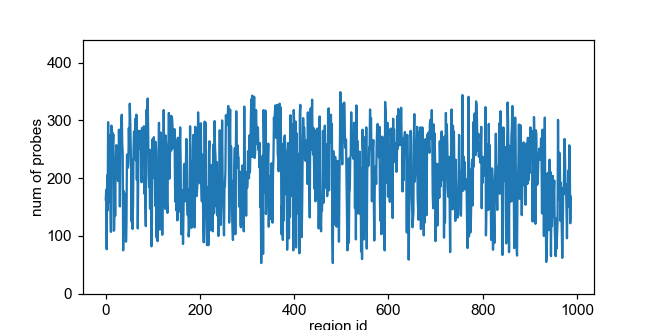

In [185]:
pb_num_dict = {_k:len(_v.kept_probes) for _k,_v in filtered_pb_dict.items()}

pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"num of probes", labelpad=1)
plt.xlabel(f"region id", labelpad=1)
plt.ylim([0, num_probes_kept*1.1])
plt.show()

In [193]:
filtered_reg_names = {}
for _reg, _pbde in filtered_pb_dict.items():
    if len(_pbde.kept_probes) > 0:
        filtered_reg_names[_reg] = list(_pbde.kept_probes.values())[0]['reg_name']
    
        

In [203]:
chr_2_region_num = {}
for _reg, _info in filtered_reg_names.items():
    _chr = _info.split('_')[0].split(':')[0]
    if _chr not in chr_2_region_num:
        chr_2_region_num[_chr] = 1
    else:
        chr_2_region_num[_chr] += 1


In [205]:
chr_2_region_names = {}
for _reg, _info in filtered_reg_names.items():
    _chr = _info.split('_')[0].split(':')[0]
    if _chr not in chr_2_region_names:
        chr_2_region_names[_chr] = [_reg]
    else:
        chr_2_region_names[_chr].append(_reg)

In [207]:
pickle.dump(chr_2_region_names, open(os.path.join(library_folder, 'chr_2_region_names.pkl'), 'wb'))

# 3. Load and asssemble probes

## 3.1 design readout mapping dict (region_to_readout)

Prepare files below using the notebook

[1_library_design_ctp11](1_library_design_ctp11.ipynb)

## 3.2 loading components

### primers
pick primer set 2,9

In [8]:
from ImageAnalysis3 import library_tools
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Primers'
primers = library_tools.assemble.load_primers([2,9], _primer_folder=primer_folder)

- Picked primer: ID: W1A03_primer_2
Name: W1A03_primer_2
Description: W1A03_primer_2
Number of features: 0
Seq('CCCGCAATGGCTGACAACCG')
- Picked primer: ID: W1A10_primer_9
Name: W1A10_primer_9
Description: W1A10_primer_9
Number of features: 0
Seq('TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG')


### readouts

In [6]:
# summarize total readout usage
region_2_readout_dict = pickle.load(open(os.path.join(library_folder, 'region_2_readout.pkl'), 'rb'))

In [7]:
region_2_readout_dict

{1: ['c36', 'c62', 'c77'],
 2: ['c17', 'c42', 'c86'],
 3: ['c34', 'c72', 'c82'],
 4: ['c57', 'c58', 'c94'],
 5: ['c41', 'c78', 'c93'],
 6: ['c61', 'c65', 'c80'],
 7: ['c66', 'c74', 'c83'],
 8: ['c23', 'c44', 'c54'],
 9: ['c4', 'c45', 'c90'],
 10: ['c51', 'c64', 'c75'],
 11: ['c12', 'c67', 'c69'],
 12: ['c15', 'c43', 'c68'],
 13: ['c30', 'c31', 'c62'],
 14: ['c10', 'c22', 'c47'],
 15: ['c5', 'c6', 'c13'],
 16: ['c3', 'c35', 'c49'],
 17: ['c39', 'c84', 'c88'],
 18: ['c8', 'c20', 'c56'],
 19: ['c24', 'c32', 'c55'],
 20: ['c18', 'c29', 'c73'],
 21: ['c53', 'c89', 'c91'],
 22: ['c7', 'c14', 'c63'],
 23: ['c0', 'c37', 'c81'],
 24: ['c70', 'c95', 'c97'],
 25: ['c26', 'c28', 'c60'],
 26: ['c11', 'c68', 'c74'],
 27: ['c21', 'c56', 'c85'],
 28: ['c54', 'c83', 'c87'],
 29: ['c2', 'c76', 'c79'],
 30: ['c48', 'c51', 'c96'],
 31: ['c8', 'c44', 'c65'],
 32: ['c1', 'c19', 'c53'],
 33: ['c5', 'c27', 'c33'],
 34: ['c67', 'c92', 'c98'],
 35: ['c10', 'c52', 'c58'],
 36: ['c12', 'c34', 'c42'],
 37: ['c4', 

In [24]:
# collect types
readout_usage_by_type = {}
for _region, _infos in region_2_readout_dict.items():
    for _info in _infos:
        if _info[0] not in readout_usage_by_type:
            readout_usage_by_type[_info[0]] = []
        if int(_info[1:]) not in readout_usage_by_type[_info[0]]:
            readout_usage_by_type[_info[0]].append(int(_info[1:]))

In [26]:
readout_usage_dict = {_type:len(_v) for _type,_v in readout_usage_by_type.items()}
readout_dict ={}

In [27]:
reload(library_tools.assemble)
overwrite_readout_usage = True
readout_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts'
readout_start = 0
num_color = 2
comb_readouts = library_tools.assemble.load_readouts(readout_usage_dict['c'], 
                                                       _type='snr_after_630', 
                                                       _readout_folder=readout_folder, 
                                                       _num_colors=2, # 750, 647
                                                       _start_id=readout_start,
                                                       )
readout_dict['c'] = comb_readouts

In [28]:
readout_dict['c']

[SeqRecord(seq=Seq('AACCACGGGCTAGAAATATCCGAGTGGCAT'), id='NDB_784', name='NDB_784', description='NDB_784', dbxrefs=[]),
 SeqRecord(seq=Seq('GCCTAAGACGTGCGACATGTTATGCTAGGC'), id='NDB_755', name='NDB_755', description='NDB_755', dbxrefs=[]),
 SeqRecord(seq=Seq('GCCGTTTCGTATATGTCGATGTCCTTAGAC'), id='NDB_826', name='NDB_826', description='NDB_826', dbxrefs=[]),
 SeqRecord(seq=Seq('TACAAATACCGGTGGTTGTCACTTTCCGAA'), id='NDB_713', name='NDB_713', description='NDB_713', dbxrefs=[]),
 SeqRecord(seq=Seq('TCCGTGACGAGATCCCGGTCGGATATGTGA'), id='NDB_865', name='NDB_865', description='NDB_865', dbxrefs=[]),
 SeqRecord(seq=Seq('GAGCTTATGACTACCACGGCATCGATTTAG'), id='NDB_725', name='NDB_725', description='NDB_725', dbxrefs=[]),
 SeqRecord(seq=Seq('CGCGAAGATCGAACTCGTTGACTAAGCATT'), id='NDB_817', name='NDB_817', description='NDB_817', dbxrefs=[]),
 SeqRecord(seq=Seq('GTGGTAAACCTCAACTACTAAGCCGCGGTA'), id='NDB_710', name='NDB_710', description='NDB_710', dbxrefs=[]),
 SeqRecord(seq=Seq('CCAGTAGTCATAGGCGCTTT

In [224]:
# save
readout_usage_file = os.path.join(library_folder, 'readout_usage.pkl')
if not os.path.isfile(readout_usage_file) or overwrite_readout_usage:
    print('save')
    pickle.dump(readout_dict, open(readout_usage_file, 'wb'))

save


## 3.3 assemble probes

In [226]:
reload(library_tools.assemble)
from ImageAnalysis3.library_tools.assemble import Assemble_probes

cand_probes, readout_summary = Assemble_probes(library_folder, filtered_pb_dict, 
                                               region_2_readout_dict, readout_dict, primers, 
                                               primer_len=20, 
                                               num_readout_per_probe=3, 
                                               unique_readout_per_probe=False,
                                               rc_targets=False, overwrite=True)

- Assemble probes by given target sequences, readouts and primers.
-- included readout types: ['c']
--- assemblying 163 probes in region: 1
--- assemblying 180 probes in region: 2
--- assemblying 77 probes in region: 3
--- assemblying 205 probes in region: 4
--- assemblying 144 probes in region: 5
--- assemblying 297 probes in region: 6
--- assemblying 210 probes in region: 7
--- assemblying 274 probes in region: 8
--- assemblying 220 probes in region: 9
--- assemblying 158 probes in region: 10
--- assemblying 156 probes in region: 11
--- assemblying 107 probes in region: 12
--- assemblying 291 probes in region: 13
--- assemblying 240 probes in region: 14
--- assemblying 279 probes in region: 15
--- assemblying 248 probes in region: 16
--- assemblying 276 probes in region: 17
--- assemblying 109 probes in region: 18
--- assemblying 111 probes in region: 19
--- assemblying 212 probes in region: 20
--- assemblying 135 probes in region: 21
--- assemblying 229 probes in region: 22
--- asse

--- assemblying 232 probes in region: 421
--- assemblying 221 probes in region: 422
--- assemblying 235 probes in region: 423
--- assemblying 294 probes in region: 424
--- assemblying 75 probes in region: 425
--- assemblying 318 probes in region: 426
--- assemblying 293 probes in region: 427
--- assemblying 268 probes in region: 428
--- assemblying 246 probes in region: 429
--- assemblying 298 probes in region: 430
--- assemblying 80 probes in region: 431
--- assemblying 278 probes in region: 432
--- assemblying 219 probes in region: 433
--- assemblying 243 probes in region: 434
--- assemblying 139 probes in region: 435
--- assemblying 167 probes in region: 436
--- assemblying 212 probes in region: 437
--- assemblying 70 probes in region: 438
--- assemblying 315 probes in region: 439
--- assemblying 327 probes in region: 440
--- assemblying 163 probes in region: 441
--- assemblying 174 probes in region: 442
--- assemblying 98 probes in region: 443
--- assemblying 159 probes in region: 

--- assemblying 107 probes in region: 625
--- assemblying 175 probes in region: 626
--- assemblying 75 probes in region: 627
--- assemblying 332 probes in region: 628
--- assemblying 315 probes in region: 629
--- assemblying 192 probes in region: 630
--- assemblying 205 probes in region: 631
--- assemblying 213 probes in region: 632
--- assemblying 296 probes in region: 633
--- assemblying 168 probes in region: 634
--- assemblying 234 probes in region: 635
--- assemblying 168 probes in region: 636
--- assemblying 255 probes in region: 637
--- assemblying 159 probes in region: 638
--- assemblying 283 probes in region: 639
--- assemblying 286 probes in region: 640
--- assemblying 263 probes in region: 641
--- assemblying 285 probes in region: 642
--- assemblying 272 probes in region: 643
--- assemblying 131 probes in region: 644
--- assemblying 303 probes in region: 645
--- assemblying 234 probes in region: 646
--- assemblying 285 probes in region: 647
--- assemblying 252 probes in regio

--- assemblying 333 probes in region: 840
--- assemblying 328 probes in region: 841
--- assemblying 299 probes in region: 842
--- assemblying 248 probes in region: 843
--- assemblying 268 probes in region: 844
--- assemblying 277 probes in region: 845
--- assemblying 237 probes in region: 846
--- assemblying 258 probes in region: 847
--- assemblying 262 probes in region: 848
--- assemblying 227 probes in region: 849
--- assemblying 248 probes in region: 850
--- assemblying 289 probes in region: 851
--- assemblying 148 probes in region: 852
--- assemblying 234 probes in region: 854
--- assemblying 192 probes in region: 855
--- assemblying 237 probes in region: 856
--- assemblying 231 probes in region: 857
--- assemblying 204 probes in region: 858
--- assemblying 234 probes in region: 859
--- assemblying 217 probes in region: 860
--- assemblying 323 probes in region: 861
--- assemblying 101 probes in region: 862
--- assemblying 150 probes in region: 863
--- assemblying 258 probes in regi

--- assemblying 221 probes in region: 1059
--- assemblying 122 probes in region: 1060
--- assemblying 168 probes in region: 1062
-- 210584 probes assembled in total.
-- saving 210584 probes into file:\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\candidate_probes.fasta
-- saving readout_summary into file:\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\readout_summary.pkl


# 4.Check quality

## 4.1 Load probes

Checking procedures could restart from here

In [4]:
# folder for this library
# candidate full-length probe filename
candidate_basename = 'candidate_probes.fasta' # old version
# load full probes
full_records = []
with open(os.path.join(library_folder, candidate_basename), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        full_records.append(record)

print(f"Total probe loaded: {len(full_records)}")

Total probe loaded: 210584


In [2]:
num_readout_per_probe = 3
primer_len=20
target_len=42
min_num_probes = 40

### 4.1.1 check primer usage

In [9]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
primer_check = check._check_primer_usage(full_records, primers[0], primers[1], primer_len=primer_len)
print(primer_check)

-- Checking primer usage, total probes: 210584
True


### 4.1.2 check region probe number

In [10]:
reload(check)
reg_size_dic, len_check = check._check_region_size(full_records, 
                                                   min_size=min_num_probes)
print(len_check)

gene: 1 -> 163
gene: 2 -> 180
gene: 3 -> 77
gene: 4 -> 205
gene: 5 -> 144
gene: 6 -> 297
gene: 7 -> 210
gene: 8 -> 274
gene: 9 -> 220
gene: 10 -> 158
gene: 11 -> 156
gene: 12 -> 107
gene: 13 -> 291
gene: 14 -> 240
gene: 15 -> 279
gene: 16 -> 248
gene: 17 -> 276
gene: 18 -> 109
gene: 19 -> 111
gene: 20 -> 212
gene: 21 -> 135
gene: 22 -> 229
gene: 23 -> 257
gene: 24 -> 257
gene: 25 -> 249
gene: 26 -> 204
gene: 27 -> 195
gene: 28 -> 198
gene: 29 -> 284
gene: 30 -> 245
gene: 31 -> 151
gene: 32 -> 247
gene: 33 -> 276
gene: 34 -> 300
gene: 35 -> 310
gene: 36 -> 260
gene: 37 -> 244
gene: 38 -> 75
gene: 39 -> 178
gene: 40 -> 142
gene: 41 -> 122
gene: 42 -> 105
gene: 43 -> 173
gene: 44 -> 90
gene: 45 -> 121
gene: 46 -> 241
gene: 47 -> 240
gene: 48 -> 218
gene: 49 -> 225
gene: 50 -> 287
gene: 51 -> 250
gene: 52 -> 329
gene: 53 -> 299
gene: 54 -> 257
gene: 55 -> 206
gene: 56 -> 125
gene: 57 -> 232
gene: 58 -> 112
gene: 59 -> 159
gene: 60 -> 252
gene: 61 -> 281
gene: 62 -> 265
gene: 63 -> 245
gene

<IPython.core.display.Javascript object>


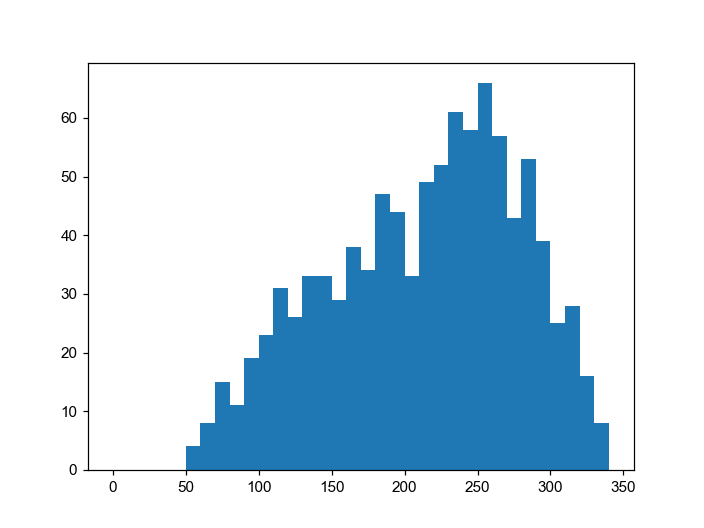

In [39]:
plt.figure()
plt.hist(list(reg_size_dic.values()), bins=np.arange(0,350,10))
plt.show()

### 4.1.3 check readout usage for each gene

In [11]:
num_readout_per_probe

3

In [13]:
reload(check)
check_readout_dict = pickle.load(open(os.path.join(library_folder, 'readout_usage.pkl'), 'rb'))

reg_readout_dic, reg2readout_check = check._check_region_to_readouts(full_records, check_readout_dict, 
                                                                     total_readout_num=num_readout_per_probe)
print(reg2readout_check)

1 -> ['NDB_856', 'NDB_935', 'NDB_946']
2 -> ['NDB_742', 'NDB_883', 'NDB_965']
3 -> ['NDB_1066', 'NDB_694', 'NDB_754']
4 -> ['NDB_752', 'NDB_832', 'NDB_940']
5 -> ['NDB_698', 'NDB_818', 'NDB_889']
6 -> ['NDB_862', 'NDB_899', 'NDB_989']
7 -> ['NDB_637', 'NDB_853', 'NDB_977']
8 -> ['NDB_1033', 'NDB_730', 'NDB_974']
9 -> ['NDB_865', 'NDB_878', 'NDB_925']
10 -> ['NDB_721', 'NDB_734', 'NDB_905']
11 -> ['NDB_647', 'NDB_847', 'NDB_941']
12 -> ['NDB_815', 'NDB_838', 'NDB_863']
13 -> ['NDB_812', 'NDB_868', 'NDB_946']
14 -> ['NDB_718', 'NDB_758', 'NDB_844']
15 -> ['NDB_683', 'NDB_725', 'NDB_817']
16 -> ['NDB_653', 'NDB_713', 'NDB_860']
17 -> ['NDB_737', 'NDB_751', 'NDB_958']
18 -> ['NDB_652', 'NDB_778', 'NDB_880']
19 -> ['NDB_1027', 'NDB_887', 'NDB_961']
20 -> ['NDB_665', 'NDB_773', 'NDB_790']
21 -> ['NDB_1028', 'NDB_824', 'NDB_866']
22 -> ['NDB_641', 'NDB_643', 'NDB_710']
23 -> ['NDB_680', 'NDB_779', 'NDB_784']
24 -> ['NDB_872', 'NDB_926', 'NDB_994']
25 -> ['NDB_661', 'NDB_835', 'NDB_901']
26 ->

### 4.1.4 check readout usage in the library

In [14]:
reload(check)
readout_reg_dic, readout2reg_check = check._check_readout_to_region(reg_readout_dic, full_records, 
                                                                    check_readout_dict, primer_len=primer_len, 
                                                                    target_len=target_len,
                                                                    probe_readout_num=num_readout_per_probe)

print(readout2reg_check)

-- extracting probes from >region:1, region:2, region:3, region:4, region:5, region:6, region:7, region:8, region:9, region:10, region:11, region:12, region:13, region:14, region:15, region:16, region:17, region:18, region:19, region:20, region:21, region:22, region:23, region:24, region:25, region:26, region:27, region:28, region:29, region:30, region:31, region:32, region:33, region:34, region:35, region:36, region:37, region:38, region:39, region:40, region:41, region:42, region:43, region:44, region:45, region:46, region:47, region:48, region:49, region:50, region:51, region:52, region:53, region:54, region:55, region:56, region:57, region:58, region:59, region:60, region:61, region:62, region:63, region:64, region:65, region:66, region:67, region:68, region:69, region:70, region:71, region:72, region:73, region:74, region:75, region:76, region:77, region:80, region:81, region:82, region:83, region:84, region:85, region:86, region:87, region:88, region:89, region:90, region:91, reg

, region:733, region:734, region:735, region:736, region:737, region:739, region:740, region:741, region:742, region:743, region:744, region:745, region:746, region:747, region:748, region:749, region:750, region:751, region:752, region:753, region:754, region:755, region:756, region:757, region:758, region:759, region:765, region:766, region:767, region:768, region:769, region:770, region:772, region:773, region:774, region:775, region:776, region:779, region:780, region:781, region:783, region:784, region:785, region:786, region:787, region:788, region:789, region:790, region:791, region:792, region:793, region:794, region:795, region:796, region:797, region:798, region:799, region:800, region:801, region:802, region:803, region:804, region:805, region:806, region:807, region:808, region:809, region:810, region:812, region:813, region:814, region:815, region:816, region:817, region:818, region:819, region:820, region:821, region:822, region:823, region:824, region:825, region:827, re

### 4.1.5 check bewteen probes

In [15]:
# construct internal map
reload(check)
int_map = check._construct_internal_map(full_records, library_folder, save=False) 

-- saving internal 17-mer map to file:\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\probe_table_17.npz


In [29]:
# internal check probes
readout_count_dic, readout_count_check = check._check_readout_in_probes(readout_reg_dic, reg_size_dic, int_map, readout_dict)
print(readout_count_check)

True


In [30]:
# check between probes
kept_records, removed_count = check._check_between_probes(full_records, int_map, 
                                                          primer_len=primer_len, 
                                                          target_len=target_len)

--- Sequence:loc_1:86240000-86260000_gene_34_pb_4_pos_274_strand_+_readouts_[NDB_941_c,NDB_712_c,NDB_910_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:85, dumped
--- Sequence:loc_1:86240000-86260000_gene_34_pb_5_pos_315_strand_+_readouts_[NDB_941_c,NDB_712_c,NDB_910_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:81, dumped
--- Sequence:loc_1:86240000-86260000_gene_34_pb_6_pos_352_strand_-_readouts_[NDB_941_c,NDB_712_c,NDB_910_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:94, dumped
--- Sequence:loc_1:86240000-86260000_gene_34_pb_7_pos_389_strand_+_readouts_[NDB_941_c,NDB_712_c,NDB_910_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:81, dumped
--- Sequence:loc_1:86240000-86260000_gene_34_pb_8_pos_426_strand_+_readouts_[NDB_941_c,NDB_712_c,NDB_910_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:85, dumped
--- Sequence:loc_1:86240000-86260000_gene_34_pb_9_pos_464_strand_-_readouts_[NDB_941_c,NDB_712_c,NDB_910_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:88,

--- Sequence:loc_3:96240000-96260000_gene_190_pb_1_pos_503_strand_+_readouts_[NDB_865_c,NDB_694_c,NDB_977_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_3:96240000-96260000_gene_190_pb_66_pos_5288_strand_-_readouts_[NDB_865_c,NDB_694_c,NDB_977_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_3:146240000-146260000_gene_210_pb_215_pos_15152_strand_+_readouts_[NDB_760_c,NDB_889_c,NDB_824_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:61, dumped
--- Sequence:loc_4:53740000-53760000_gene_238_pb_250_pos_19614_strand_+_readouts_[NDB_643_c,NDB_929_c,NDB_872_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:58, dumped
--- Sequence:loc_4:53740000-53760000_gene_238_pb_251_pos_19682_strand_-_readouts_[NDB_643_c,NDB_929_c,NDB_872_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:57, dumped
--- Sequence:loc_4:91240000-91260000_gene_253_pb_78_pos_5217_strand_-_readouts_[NDB_752_c,NDB_935_c,NDB_751_c]_primers_[W1A03_primer_2,W1A1

--- Sequence:loc_6:146240000-146260000_gene_399_pb_139_pos_11236_strand_+_readouts_[NDB_698_c,NDB_977_c,NDB_824_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:65, dumped
--- Sequence:loc_6:146240000-146260000_gene_399_pb_140_pos_11303_strand_+_readouts_[NDB_698_c,NDB_977_c,NDB_824_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:73, dumped
--- Sequence:loc_6:146240000-146260000_gene_399_pb_141_pos_11410_strand_+_readouts_[NDB_698_c,NDB_977_c,NDB_824_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:84, dumped
--- Sequence:loc_6:146240000-146260000_gene_399_pb_143_pos_11755_strand_+_readouts_[NDB_698_c,NDB_977_c,NDB_824_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:83, dumped
--- Sequence:loc_6:146240000-146260000_gene_399_pb_144_pos_11860_strand_+_readouts_[NDB_698_c,NDB_977_c,NDB_824_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_7:98740000-98760000_gene_440_pb_224_pos_14017_strand_+_readouts_[NDB_817_c,NDB_647_c,NDB_712_c]_primers_[W1A

--- Sequence:loc_12:71240000-71260000_gene_692_pb_27_pos_2198_strand_+_readouts_[NDB_718_c,NDB_881_c,NDB_824_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:54, dumped
--- Sequence:loc_12:106240000-106260000_gene_706_pb_168_pos_11458_strand_+_readouts_[NDB_778_c,NDB_634_c,NDB_853_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:60, dumped
--- Sequence:loc_12:106240000-106260000_gene_706_pb_169_pos_11495_strand_+_readouts_[NDB_778_c,NDB_634_c,NDB_853_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:58, dumped
--- Sequence:loc_12:116240000-116260000_gene_710_pb_123_pos_8464_strand_-_readouts_[NDB_905_c,NDB_779_c,NDB_872_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:83, dumped
--- Sequence:loc_12:116240000-116260000_gene_710_pb_124_pos_8532_strand_+_readouts_[NDB_905_c,NDB_779_c,NDB_872_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:71, dumped
--- Sequence:loc_12:116240000-116260000_gene_710_pb_127_pos_9493_strand_-_readouts_[NDB_905_c,NDB_779_c,NDB_872_c]_primers_[W1

--- Sequence:loc_15:43740000-43760000_gene_828_pb_98_pos_18814_strand_+_readouts_[NDB_713_c,NDB_946_c,NDB_694_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:59, dumped
--- Sequence:loc_15:43740000-43760000_gene_828_pb_99_pos_18901_strand_+_readouts_[NDB_713_c,NDB_946_c,NDB_694_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:64, dumped
--- Sequence:loc_15:43740000-43760000_gene_828_pb_100_pos_18992_strand_+_readouts_[NDB_713_c,NDB_946_c,NDB_694_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:66, dumped
--- Sequence:loc_15:78740000-78760000_gene_842_pb_178_pos_13175_strand_+_readouts_[NDB_974_c,NDB_746_c,NDB_910_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:62, dumped
--- Sequence:loc_15:86240000-86260000_gene_845_pb_86_pos_5353_strand_+_readouts_[NDB_725_c,NDB_847_c,NDB_835_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:59, dumped
--- Sequence:loc_15:86240000-86260000_gene_845_pb_87_pos_5391_strand_-_readouts_[NDB_725_c,NDB_847_c,NDB_835_c]_primers_[W1A03_primer_

-- total probes removed by internal screening: 249


In [31]:
del(int_map)

### 4.1.6 finish checking, save

In [32]:
# save kept records
with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'w') as output_handle:
    SeqIO.write(kept_records, output_handle, "fasta")

## 4.2 BLAST screening of probes

create the local blast database by:
```bash
makeblastdb -in C:\Users\puzheng\Documents\Tools\lowercase_masked\Mus_musculus.GRCm38.dna_sm.merged.fa -dbtype nucl -parse_seqids -out GRCm38_ensembl -title "Mouse chromosomes soft masked" -blastdb_version 4![image.png](attachment:image.png)
```

The outputs are:
```bash
Building a new DB, current time: 03/30/2021 21:49:18
New DB name:   C:\Users\puzheng\Documents\Tools\GRCm38_ensembl
New DB title:  Mouse chromosomes soft masked
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 66 sequences in 42.2668 seconds.
```

In [33]:
blast_database = os.path.join(reference_folder, 'blast_database', 'GRCm38_ensembl')

check.Blast_probes(kept_records, library_folder, num_threads=32, 
                   blast_db=blast_database, blast_evalue=100, overwrite=True)

- Blast probe against \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl\blast_database\GRCm38_ensembl
-- number of probes loaded: 210335
-- processing region: 1 with 163 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_1.fasta
--- *blasting region: 1
--- total time for blast 1: 11.298415660858154
-- processing region: 10 with 158 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_10.fasta
--- *blasting region: 10
--- total time for blast 10: 7.147331714630127
-- processing region: 100 with 82 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_100.fasta
--- *blasting region: 100
--- total time for blast 100: 5.612882614135742
-- processing region: 1000 with 55 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Librar

--- total time for blast 1031: 8.029948949813843
-- processing region: 1032 with 163 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_1032.fasta
--- *blasting region: 1032
--- total time for blast 1032: 9.001835584640503
-- processing region: 1033 with 244 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_1033.fasta
--- *blasting region: 1033
--- total time for blast 1033: 7.4063403606414795
-- processing region: 1034 with 224 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_1034.fasta
--- *blasting region: 1034
--- total time for blast 1034: 8.648493766784668
-- processing region: 1035 with 126 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_1035.fasta
--- *blasting region: 1035
---

--- total time for blast 110: 9.135655403137207
-- processing region: 111 with 97 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_111.fasta
--- *blasting region: 111
--- total time for blast 111: 5.679330587387085
-- processing region: 112 with 205 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_112.fasta
--- *blasting region: 112
--- total time for blast 112: 9.724242448806763
-- processing region: 113 with 91 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_113.fasta
--- *blasting region: 113
--- total time for blast 113: 6.779293537139893
-- processing region: 114 with 163 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_114.fasta
--- *blasting region: 114
--- total time for bla

--- total time for blast 142: 11.665688753128052
-- processing region: 143 with 248 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_143.fasta
--- *blasting region: 143
--- total time for blast 143: 8.781205415725708
-- processing region: 144 with 305 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_144.fasta
--- *blasting region: 144
--- total time for blast 144: 13.12364912033081
-- processing region: 145 with 302 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_145.fasta
--- *blasting region: 145
--- total time for blast 145: 11.611449718475342
-- processing region: 146 with 279 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_146.fasta
--- *blasting region: 146
--- total time for

--- total time for blast 175: 11.393676996231079
-- processing region: 176 with 213 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_176.fasta
--- *blasting region: 176
--- total time for blast 176: 8.82885456085205
-- processing region: 177 with 268 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_177.fasta
--- *blasting region: 177
--- total time for blast 177: 13.503256797790527
-- processing region: 178 with 261 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_178.fasta
--- *blasting region: 178
--- total time for blast 178: 11.63425064086914
-- processing region: 179 with 163 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_179.fasta
--- *blasting region: 179
--- total time for 

--- total time for blast 207: 11.939893007278442
-- processing region: 208 with 191 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_208.fasta
--- *blasting region: 208
--- total time for blast 208: 8.098031759262085
-- processing region: 209 with 290 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_209.fasta
--- *blasting region: 209
--- total time for blast 209: 10.910980463027954
-- processing region: 21 with 135 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_21.fasta
--- *blasting region: 21
--- total time for blast 21: 9.001704692840576
-- processing region: 210 with 294 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_210.fasta
--- *blasting region: 210
--- total time for bla

--- total time for blast 24: 13.324691772460938
-- processing region: 240 with 139 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_240.fasta
--- *blasting region: 240
--- total time for blast 240: 7.360535144805908
-- processing region: 242 with 299 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_242.fasta
--- *blasting region: 242
--- total time for blast 242: 11.148815393447876
-- processing region: 243 with 251 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_243.fasta
--- *blasting region: 243
--- total time for blast 243: 8.821013450622559
-- processing region: 244 with 237 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_244.fasta
--- *blasting region: 244
--- total time for 

--- total time for blast 272: 10.807867050170898
-- processing region: 273 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_273.fasta
--- *blasting region: 273
--- total time for blast 273: 9.96724796295166
-- processing region: 274 with 123 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_274.fasta
--- *blasting region: 274
--- total time for blast 274: 12.881633758544922
-- processing region: 276 with 248 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_276.fasta
--- *blasting region: 276
--- total time for blast 276: 9.810691356658936
-- processing region: 277 with 319 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_277.fasta
--- *blasting region: 277
--- total time for 

--- total time for blast 305: 16.951761484146118
-- processing region: 306 with 188 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_306.fasta
--- *blasting region: 306
--- total time for blast 306: 8.279724359512329
-- processing region: 307 with 149 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_307.fasta
--- *blasting region: 307
--- total time for blast 307: 8.8944730758667
-- processing region: 308 with 108 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_308.fasta
--- *blasting region: 308
--- total time for blast 308: 6.976195812225342
-- processing region: 309 with 322 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_309.fasta
--- *blasting region: 309
--- total time for bl

--- total time for blast 337: 12.539339542388916
-- processing region: 338 with 259 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_338.fasta
--- *blasting region: 338
--- total time for blast 338: 10.421015739440918
-- processing region: 339 with 288 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_339.fasta
--- *blasting region: 339
--- total time for blast 339: 12.66845989227295
-- processing region: 34 with 294 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_34.fasta
--- *blasting region: 34
--- total time for blast 34: 12.026940107345581
-- processing region: 340 with 249 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_340.fasta
--- *blasting region: 340
--- total time for bl

--- total time for blast 369: 10.837334156036377
-- processing region: 37 with 244 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_37.fasta
--- *blasting region: 37
--- total time for blast 37: 7.918634414672852
-- processing region: 370 with 175 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_370.fasta
--- *blasting region: 370
--- total time for blast 370: 7.235055685043335
-- processing region: 371 with 123 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_371.fasta
--- *blasting region: 371
--- total time for blast 371: 15.231513261795044
-- processing region: 372 with 210 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_372.fasta
--- *blasting region: 372
--- total time for bla

--- total time for blast 40: 6.200113296508789
-- processing region: 400 with 245 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_400.fasta
--- *blasting region: 400
--- total time for blast 400: 10.87867283821106
-- processing region: 403 with 172 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_403.fasta
--- *blasting region: 403
--- total time for blast 403: 14.512754917144775
-- processing region: 407 with 211 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_407.fasta
--- *blasting region: 407
--- total time for blast 407: 11.060325384140015
-- processing region: 408 with 76 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_408.fasta
--- *blasting region: 408
--- total time for b

--- total time for blast 439: 11.30353331565857
-- processing region: 44 with 90 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_44.fasta
--- *blasting region: 44
--- total time for blast 44: 7.447296142578125
-- processing region: 440 with 325 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_440.fasta
--- *blasting region: 440
--- total time for blast 440: 13.252742767333984
-- processing region: 441 with 163 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_441.fasta
--- *blasting region: 441
--- total time for blast 441: 9.0118408203125
-- processing region: 442 with 174 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_442.fasta
--- *blasting region: 442
--- total time for blast 4

--- total time for blast 472: 14.67583703994751
-- processing region: 473 with 182 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_473.fasta
--- *blasting region: 473
--- total time for blast 473: 7.254590272903442
-- processing region: 474 with 283 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_474.fasta
--- *blasting region: 474
--- total time for blast 474: 10.699969053268433
-- processing region: 475 with 160 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_475.fasta
--- *blasting region: 475
--- total time for blast 475: 7.8618550300598145
-- processing region: 476 with 220 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_476.fasta
--- *blasting region: 476
--- total time for

--- total time for blast 502: 10.461658716201782
-- processing region: 503 with 321 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_503.fasta
--- *blasting region: 503
--- total time for blast 503: 14.87893009185791
-- processing region: 504 with 179 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_504.fasta
--- *blasting region: 504
--- total time for blast 504: 10.839454889297485
-- processing region: 505 with 273 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_505.fasta
--- *blasting region: 505
--- total time for blast 505: 10.567364692687988
-- processing region: 506 with 279 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_506.fasta
--- *blasting region: 506
--- total time fo

--- total time for blast 534: 9.574130773544312
-- processing region: 535 with 268 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_535.fasta
--- *blasting region: 535
--- total time for blast 535: 9.3654146194458
-- processing region: 536 with 269 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_536.fasta
--- *blasting region: 536
--- total time for blast 536: 10.946852207183838
-- processing region: 537 with 331 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_537.fasta
--- *blasting region: 537
--- total time for blast 537: 13.60220742225647
-- processing region: 538 with 304 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_538.fasta
--- *blasting region: 538
--- total time for bl

--- total time for blast 567: 7.759770631790161
-- processing region: 568 with 139 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_568.fasta
--- *blasting region: 568
--- total time for blast 568: 13.28598403930664
-- processing region: 569 with 166 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_569.fasta
--- *blasting region: 569
--- total time for blast 569: 5.676033973693848
-- processing region: 57 with 232 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_57.fasta
--- *blasting region: 57
--- total time for blast 57: 7.7214062213897705
-- processing region: 570 with 241 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_570.fasta
--- *blasting region: 570
--- total time for blas

--- total time for blast 598: 6.194962024688721
-- processing region: 599 with 258 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_599.fasta
--- *blasting region: 599
--- total time for blast 599: 15.639772176742554
-- processing region: 6 with 297 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_6.fasta
--- *blasting region: 6
--- total time for blast 6: 10.005953550338745
-- processing region: 60 with 252 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_60.fasta
--- *blasting region: 60
--- total time for blast 60: 9.559448719024658
-- processing region: 600 with 253 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_600.fasta
--- *blasting region: 600
--- total time for blast 600: 

--- total time for blast 63: 8.62207317352295
-- processing region: 630 with 192 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_630.fasta
--- *blasting region: 630
--- total time for blast 630: 11.045226812362671
-- processing region: 631 with 205 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_631.fasta
--- *blasting region: 631
--- total time for blast 631: 9.808301210403442
-- processing region: 632 with 213 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_632.fasta
--- *blasting region: 632
--- total time for blast 632: 9.774118423461914
-- processing region: 633 with 296 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_633.fasta
--- *blasting region: 633
--- total time for bl

--- total time for blast 660: 8.869733572006226
-- processing region: 661 with 284 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_661.fasta
--- *blasting region: 661
--- total time for blast 661: 12.934610843658447
-- processing region: 662 with 322 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_662.fasta
--- *blasting region: 662
--- total time for blast 662: 12.18977165222168
-- processing region: 663 with 271 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_663.fasta
--- *blasting region: 663
--- total time for blast 663: 11.293832063674927
-- processing region: 665 with 270 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_665.fasta
--- *blasting region: 665
--- total time for

--- total time for blast 694: 8.245142936706543
-- processing region: 695 with 211 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_695.fasta
--- *blasting region: 695
--- total time for blast 695: 9.841764211654663
-- processing region: 696 with 266 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_696.fasta
--- *blasting region: 696
--- total time for blast 696: 9.457723617553711
-- processing region: 697 with 242 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_697.fasta
--- *blasting region: 697
--- total time for blast 697: 9.101778745651245
-- processing region: 698 with 255 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_698.fasta
--- *blasting region: 698
--- total time for b

--- total time for blast 728: 12.205148220062256
-- processing region: 729 with 244 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_729.fasta
--- *blasting region: 729
--- total time for blast 729: 22.33016562461853
-- processing region: 73 with 282 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_73.fasta
--- *blasting region: 73
--- total time for blast 73: 9.320429563522339
-- processing region: 730 with 295 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_730.fasta
--- *blasting region: 730
--- total time for blast 730: 11.802908182144165
-- processing region: 731 with 301 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_731.fasta
--- *blasting region: 731
--- total time for bla

--- total time for blast 76: 10.114533424377441
-- processing region: 765 with 242 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_765.fasta
--- *blasting region: 765
--- total time for blast 765: 11.065551996231079
-- processing region: 766 with 97 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_766.fasta
--- *blasting region: 766
--- total time for blast 766: 7.359191656112671
-- processing region: 767 with 272 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_767.fasta
--- *blasting region: 767
--- total time for blast 767: 9.542107105255127
-- processing region: 768 with 123 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_768.fasta
--- *blasting region: 768
--- total time for b

--- total time for blast 80: 10.49958848953247
-- processing region: 800 with 169 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_800.fasta
--- *blasting region: 800
--- total time for blast 800: 7.0898706912994385
-- processing region: 801 with 200 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_801.fasta
--- *blasting region: 801
--- total time for blast 801: 10.283659219741821
-- processing region: 802 with 275 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_802.fasta
--- *blasting region: 802
--- total time for blast 802: 8.330924272537231
-- processing region: 803 with 188 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_803.fasta
--- *blasting region: 803
--- total time for 

--- total time for blast 832: 10.601896524429321
-- processing region: 833 with 153 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_833.fasta
--- *blasting region: 833
--- total time for blast 833: 12.150683164596558
-- processing region: 834 with 297 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_834.fasta
--- *blasting region: 834
--- total time for blast 834: 9.690229177474976
-- processing region: 835 with 220 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_835.fasta
--- *blasting region: 835
--- total time for blast 835: 14.07128381729126
-- processing region: 836 with 296 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_836.fasta
--- *blasting region: 836
--- total time for

--- total time for blast 864: 9.790291547775269
-- processing region: 865 with 259 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_865.fasta
--- *blasting region: 865
--- total time for blast 865: 12.275944709777832
-- processing region: 866 with 251 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_866.fasta
--- *blasting region: 866
--- total time for blast 866: 10.985858678817749
-- processing region: 867 with 145 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_867.fasta
--- *blasting region: 867
--- total time for blast 867: 8.443289518356323
-- processing region: 868 with 294 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_868.fasta
--- *blasting region: 868
--- total time for

--- total time for blast 898: 19.10613775253296
-- processing region: 899 with 179 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_899.fasta
--- *blasting region: 899
--- total time for blast 899: 9.518476963043213
-- processing region: 9 with 220 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_9.fasta
--- *blasting region: 9
--- total time for blast 9: 8.588090896606445
-- processing region: 90 with 315 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_90.fasta
--- *blasting region: 90
--- total time for blast 90: 11.671586036682129
-- processing region: 900 with 67 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_900.fasta
--- *blasting region: 900
--- total time for blast 900: 8.

--- total time for blast 928: 7.837761163711548
-- processing region: 929 with 125 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_929.fasta
--- *blasting region: 929
--- total time for blast 929: 12.119728088378906
-- processing region: 93 with 284 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_93.fasta
--- *blasting region: 93
--- total time for blast 93: 11.370543956756592
-- processing region: 930 with 81 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_930.fasta
--- *blasting region: 930
--- total time for blast 930: 16.169583797454834
-- processing region: 932 with 66 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_932.fasta
--- *blasting region: 932
--- total time for blas

--- total time for blast 96: 9.930009365081787
-- processing region: 960 with 288 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_960.fasta
--- *blasting region: 960
--- total time for blast 960: 18.17253541946411
-- processing region: 961 with 284 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_961.fasta
--- *blasting region: 961
--- total time for blast 961: 10.132984399795532
-- processing region: 962 with 278 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_962.fasta
--- *blasting region: 962
--- total time for blast 962: 10.54274845123291
-- processing region: 963 with 282 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_963.fasta
--- *blasting region: 963
--- total time for b

--- total time for blast 995: 9.972090005874634
-- processing region: 997 with 305 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_997.fasta
--- *blasting region: 997
--- total time for blast 997: 11.520379066467285
-- processing region: 998 with 149 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_998.fasta
--- *blasting region: 998
--- total time for blast 998: 9.132471323013306
-- processing region: 999 with 133 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\blast\probe_gene_999.fasta
--- *blasting region: 999
--- total time for blast 999: 13.170165538787842


### 4.2.1 screen probe by blast results

This step has 2 different cutoffs:

hard_cutoff: whether a probe has any ~40mer hit somewhere else, if so just dump the probe

soft_cutoff: whether a probe has a lot of ~20mer off-target hits, if exceed certain amount then dump the probe

In [40]:
# screen
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
num_probes_per_region = 120
kept_pbs, blast_keep_dic, hard_count_list, soft_count_list = check.Screening_Probes_by_Blast(library_folder, 
                                                                                             num_probes_per_region,
                                                                                             hard_thres=target_len,
                                                                                             soft_count_th=50,
                                                                                             )

- Number of probes loaded: 210335
- Number of regions in this library: 988
-- checking probes in region: 1
--- gene=1, id=67 removed by soft count = 586
--- gene=1, id=78 removed by soft count = 500
--- gene=1, id=83 removed by soft count = 107
--- gene=1, id=92 removed by soft count = 153
--- gene=1, id=93 removed by soft count = 63
--- gene=1, id=94 removed by soft count = 159
--- gene=1, id=113 removed by soft count = 70
--- gene=1, id=122 removed by soft count = 56
--- gene=1, id=133 removed by soft count = 105
--- gene=1, id=136 removed by soft count = 87
--- gene=1, id=137 removed by soft count = 117
--- gene=1, id=142 removed by soft count = 86
--- gene=1, id=144 removed by soft count = 58
--- gene=1, id=146 removed by soft count = 63
--- gene=1, id=147 removed by soft count = 61
--- gene=1, id=148 removed by soft count = 75
--- gene=1, id=154 removed by soft count = 65
--- gene=1, id=157 removed by soft count = 77
--- gene=1, id=158 removed by soft count = 59
--- gene=1, id=160

--- gene=16, id=144 removed by soft count = 75
--- gene=16, id=154 removed by soft count = 77
--- gene=16, id=183 removed by soft count = 78
--- gene=16, id=247 removed by soft count = 165
--- number of probes: 248 , kept by blast: 239 , if remove dups: 239
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 17
--- gene=17, id=56 removed by soft count = 3644
--- gene=17, id=57 removed by soft count = 236
--- gene=17, id=235 removed by soft count = 54
--- number of probes: 276 , kept by blast: 273 , if remove dups: 273
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 18
--- gene=18, id=45 removed by soft count = 195
--- gene=18, id=50 removed by soft count = 65
--- gene=18, id=99 removed by soft count = 1071
--- gene=18, id=100 removed by soft count = 254
--- gene=18, id=101 removed by soft count = 87
--- gene=18, id=102

--- gene=37, id=20 removed by soft count = 124
--- gene=37, id=228 removed by soft count = 52
--- gene=37, id=230 removed by soft count = 203
--- gene=37, id=231 removed by soft count = 88
--- number of probes: 244 , kept by blast: 240 , if remove dups: 240
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 38
--- gene=38, id=13 removed by soft count = 65
--- gene=38, id=34 removed by soft count = 78
--- gene=38, id=55 removed by soft count = 155
--- gene=38, id=56 removed by soft count = 62
--- gene=38, id=63 removed by soft count = 54
--- gene=38, id=68 removed by soft count = 70
--- number of probes: 75 , kept by blast: 69 , if remove dups: 69
-- number of probes kept for this region: 69
-- checking probes in region: 39
--- gene=39, id=62 removed by soft count = 67
--- gene=39, id=77 removed by soft count = 76
--- gene=39, id=101 removed by soft count = 118
--- gene=39, id=123 removed by soft count =

--- gene=54, id=1 removed by soft count = 154
--- gene=54, id=3 removed by soft count = 382
--- gene=54, id=58 removed by soft count = 84
--- gene=54, id=60 removed by soft count = 128
--- gene=54, id=74 removed by soft count = 181
--- gene=54, id=127 removed by soft count = 506
--- gene=54, id=151 removed by soft count = 58
--- gene=54, id=171 removed by soft count = 352
--- gene=54, id=180 removed by soft count = 63
--- gene=54, id=209 removed by soft count = 1405
--- number of probes: 257 , kept by blast: 247 , if remove dups: 247
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 55
--- gene=55, id=127 removed by soft count = 168
--- number of probes: 206 , kept by blast: 205 , if remove dups: 205
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 56
--- gene=56, id=12 removed by soft count = 81
--- gene=56, id=13 re

--- gene=76, id=261 removed by soft count = 261
--- number of probes: 265 , kept by blast: 262 , if remove dups: 262
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 77
--- gene=77, id=18 removed by soft count = 81
--- gene=77, id=180 removed by soft count = 145
--- gene=77, id=190 removed by soft count = 55
--- number of probes: 193 , kept by blast: 190 , if remove dups: 190
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 80
--- number of probes: 287 , kept by blast: 287 , if remove dups: 287
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 81
--- gene=81, id=2 removed by soft count = 99
--- gene=81, id=42 removed by soft count = 212
--- gene=81, id=43 removed by soft count = 106
--- gene=81, id=44 removed by soft count = 124
--- 

--- gene=100, id=2 removed by soft count = 336
--- gene=100, id=3 removed by soft count = 72
--- gene=100, id=15 removed by soft count = 82
--- gene=100, id=26 removed by soft count = 83
--- gene=100, id=28 removed by soft count = 108
--- gene=100, id=71 removed by soft count = 106
--- number of probes: 82 , kept by blast: 76 , if remove dups: 76
-- number of probes kept for this region: 76
-- checking probes in region: 101
--- gene=101, id=9 removed by soft count = 77
--- gene=101, id=14 removed by soft count = 468
--- gene=101, id=16 removed by soft count = 1158
--- gene=101, id=17 removed by soft count = 153
--- gene=101, id=22 removed by soft count = 201
--- number of probes: 122 , kept by blast: 117 , if remove dups: 117
--- remove duplicated probes
-- number of probes kept for this region: 117
-- checking probes in region: 102
--- gene=102, id=11 removed by soft count = 89
--- gene=102, id=12 removed by soft count = 77
--- gene=102, id=13 removed by soft count = 90
--- gene=102, 

--- gene=119, id=145 removed by soft count = 54
--- gene=119, id=202 removed by soft count = 94
--- number of probes: 203 , kept by blast: 198 , if remove dups: 198
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 120
--- gene=120, id=2 removed by soft count = 107
--- gene=120, id=15 removed by soft count = 52
--- gene=120, id=83 removed by soft count = 198
--- gene=120, id=97 removed by soft count = 270
--- gene=120, id=129 removed by soft count = 273
--- number of probes: 279 , kept by blast: 274 , if remove dups: 274
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 121
--- number of probes: 223 , kept by blast: 223 , if remove dups: 223
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 122
--- gene=122, id=83 removed by soft count

--- gene=141, id=61 removed by soft count = 89
--- gene=141, id=103 removed by soft count = 60
--- gene=141, id=122 removed by soft count = 112
--- gene=141, id=246 removed by soft count = 84
--- gene=141, id=257 removed by soft count = 91
--- number of probes: 259 , kept by blast: 253 , if remove dups: 253
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 142
--- gene=142, id=123 removed by soft count = 104
--- gene=142, id=188 removed by soft count = 225
--- gene=142, id=191 removed by soft count = 87
--- gene=142, id=214 removed by soft count = 66
--- gene=142, id=299 removed by soft count = 168
--- number of probes: 308 , kept by blast: 303 , if remove dups: 301
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 143
--- gene=143, id=3 removed by soft count = 63
--- gene=143, id=138 removed by soft count = 125
--- ge

--- gene=158, id=113 removed by soft count = 6359
--- number of probes: 127 , kept by blast: 100 , if remove dups: 100
--- remove duplicated probes
-- number of probes kept for this region: 100
-- checking probes in region: 159
--- number of probes: 270 , kept by blast: 270 , if remove dups: 270
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 160
--- gene=160, id=8 removed by soft count = 142
--- gene=160, id=90 removed by soft count = 204
--- gene=160, id=91 removed by soft count = 56
--- gene=160, id=94 removed by soft count = 288
--- gene=160, id=97 removed by soft count = 980
--- gene=160, id=110 removed by soft count = 189
--- gene=160, id=114 removed by soft count = 151
--- gene=160, id=117 removed by soft count = 73
--- gene=160, id=118 removed by soft count = 56
--- gene=160, id=133 removed by soft count = 60
--- gene=160, id=136 removed by soft count = 72
--- gene=160, id=137 removed by soft

--- number of probes: 261 , kept by blast: 261 , if remove dups: 261
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 179
--- gene=179, id=79 removed by soft count = 118
--- gene=179, id=89 removed by soft count = 91
--- gene=179, id=90 removed by soft count = 58
--- gene=179, id=91 removed by soft count = 74
--- gene=179, id=92 removed by soft count = 138
--- gene=179, id=113 removed by soft count = 83
--- number of probes: 163 , kept by blast: 157 , if remove dups: 157
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 180
--- gene=180, id=0 removed by soft count = 65
--- gene=180, id=1 removed by soft count = 1167
--- gene=180, id=2 removed by soft count = 84
--- gene=180, id=3 removed by soft count = 157
--- gene=180, id=5 removed by soft count = 820
--- gene=180, id=7 removed by soft count = 643
--- gene=180, id=9

--- gene=195, id=62 removed by soft count = 572
--- number of probes: 186 , kept by blast: 182 , if remove dups: 182
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 196
--- gene=196, id=7 removed by soft count = 108
--- gene=196, id=8 removed by soft count = 504
--- gene=196, id=9 removed by soft count = 226
--- gene=196, id=10 removed by soft count = 80
--- gene=196, id=12 removed by soft count = 274
--- gene=196, id=14 removed by soft count = 1032
--- gene=196, id=15 removed by soft count = 62
--- gene=196, id=16 removed by soft count = 1287
--- gene=196, id=18 removed by soft count = 2812
--- gene=196, id=19 removed by soft count = 85
--- gene=196, id=21 removed by soft count = 79
--- gene=196, id=30 removed by soft count = 77
--- gene=196, id=47 removed by soft count = 70
--- gene=196, id=48 removed by soft count = 153
--- gene=196, id=52 removed by soft count = 138
--- gene=196, id=60 removed by

--- gene=213, id=55 removed by soft count = 92
--- gene=213, id=106 removed by soft count = 165
--- gene=213, id=139 removed by soft count = 87
--- gene=213, id=149 removed by soft count = 123
--- gene=213, id=150 removed by soft count = 478
--- number of probes: 241 , kept by blast: 236 , if remove dups: 234
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 214
--- gene=214, id=5 removed by soft count = 126
--- gene=214, id=11 removed by soft count = 98
--- gene=214, id=19 removed by soft count = 69
--- gene=214, id=20 removed by soft count = 71
--- gene=214, id=67 removed by soft count = 783
--- gene=214, id=83 removed by soft count = 566
--- gene=214, id=87 removed by soft count = 89
--- gene=214, id=137 removed by soft count = 68
--- gene=214, id=169 removed by soft count = 78
--- gene=214, id=170 removed by soft count = 65
--- number of probes: 180 , kept by blast: 170 , if remove dups: 170
--- re

--- gene=234, id=11 removed by soft count = 438
--- gene=234, id=111 removed by soft count = 81
--- gene=234, id=134 removed by soft count = 143
--- gene=234, id=155 removed by soft count = 97
--- number of probes: 194 , kept by blast: 190 , if remove dups: 190
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 235
--- gene=235, id=40 removed by soft count = 65
--- gene=235, id=48 removed by soft count = 88
--- gene=235, id=121 removed by soft count = 125
--- gene=235, id=122 removed by soft count = 146
--- number of probes: 151 , kept by blast: 147 , if remove dups: 147
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 236
--- gene=236, id=38 removed by soft count = 110
--- gene=236, id=49 removed by soft count = 78
--- gene=236, id=50 removed by soft count = 295
--- number of probes: 220 , kept by blast: 217 , if remo

--- gene=254, id=27 removed by soft count = 3291
--- gene=254, id=51 removed by soft count = 51
--- gene=254, id=52 removed by soft count = 103
--- gene=254, id=53 removed by soft count = 471
--- gene=254, id=96 removed by soft count = 6458
--- number of probes: 139 , kept by blast: 133 , if remove dups: 133
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 255
--- gene=255, id=0 removed by soft count = 358
--- gene=255, id=2 removed by soft count = 72
--- gene=255, id=3 removed by soft count = 92
--- gene=255, id=4 removed by soft count = 141
--- gene=255, id=18 removed by soft count = 890
--- gene=255, id=31 removed by soft count = 121
--- gene=255, id=117 removed by soft count = 320
--- number of probes: 119 , kept by blast: 112 , if remove dups: 112
--- remove duplicated probes
-- number of probes kept for this region: 112
-- checking probes in region: 256
--- gene=256, id=38 removed by soft count 

--- gene=276, id=29 removed by soft count = 100
--- gene=276, id=224 removed by soft count = 65
--- number of probes: 248 , kept by blast: 246 , if remove dups: 246
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 277
--- gene=277, id=104 removed by soft count = 1959
--- gene=277, id=105 removed by soft count = 72
--- gene=277, id=205 removed by soft count = 67
--- gene=277, id=288 removed by soft count = 55
--- number of probes: 319 , kept by blast: 315 , if remove dups: 315
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 278
--- gene=278, id=11 removed by soft count = 125
--- gene=278, id=12 removed by soft count = 143
--- gene=278, id=13 removed by soft count = 90
--- number of probes: 156 , kept by blast: 153 , if remove dups: 153
--- remove duplicated probes
--- keep probes in the center
-- number of probes kep

--- gene=299, id=110 removed by soft count = 58
--- gene=299, id=117 removed by soft count = 63
--- gene=299, id=118 removed by soft count = 82
--- gene=299, id=189 removed by soft count = 273
--- gene=299, id=190 removed by soft count = 858
--- number of probes: 212 , kept by blast: 207 , if remove dups: 207
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 300
--- gene=300, id=54 removed by soft count = 373
--- gene=300, id=56 removed by soft count = 812
--- gene=300, id=60 removed by soft count = 79
--- gene=300, id=159 removed by soft count = 1442
--- gene=300, id=160 removed by soft count = 204
--- gene=300, id=161 removed by soft count = 96
--- gene=300, id=173 removed by soft count = 67
--- number of probes: 174 , kept by blast: 167 , if remove dups: 167
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 301
--- 

--- number of probes: 210 , kept by blast: 203 , if remove dups: 203
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 323
--- gene=323, id=5 removed by soft count = 69
--- gene=323, id=6 removed by soft count = 178
--- gene=323, id=15 removed by soft count = 68
--- gene=323, id=18 removed by soft count = 112
--- gene=323, id=56 removed by soft count = 146
--- gene=323, id=127 removed by soft count = 978
--- gene=323, id=231 removed by soft count = 99
--- number of probes: 242 , kept by blast: 235 , if remove dups: 235
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 324
--- gene=324, id=115 removed by hard count = 3
--- gene=324, id=143 removed by soft count = 61
--- gene=324, id=301 removed by soft count = 89
--- gene=324, id=302 removed by soft count = 72
--- number of probes: 303 , kept by blast: 299 , if remove d

--- gene=347, id=9 removed by soft count = 81
--- gene=347, id=10 removed by soft count = 914
--- gene=347, id=14 removed by soft count = 631
--- gene=347, id=50 removed by soft count = 177
--- number of probes: 53 , kept by blast: 49 , if remove dups: 49
-- number of probes kept for this region: 49
-- checking probes in region: 348
--- gene=348, id=0 removed by soft count = 332
--- gene=348, id=14 removed by soft count = 55
--- gene=348, id=74 removed by soft count = 95
--- gene=348, id=75 removed by soft count = 152
--- gene=348, id=80 removed by soft count = 62
--- gene=348, id=84 removed by soft count = 707
--- number of probes: 139 , kept by blast: 133 , if remove dups: 132
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 349
--- number of probes: 188 , kept by blast: 188 , if remove dups: 187
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120

--- gene=367, id=28 removed by soft count = 331
--- gene=367, id=29 removed by soft count = 2693
--- gene=367, id=31 removed by soft count = 73
--- gene=367, id=33 removed by soft count = 572
--- gene=367, id=34 removed by soft count = 122
--- gene=367, id=35 removed by soft count = 75
--- gene=367, id=36 removed by soft count = 88
--- gene=367, id=37 removed by soft count = 126
--- gene=367, id=38 removed by soft count = 105
--- gene=367, id=39 removed by soft count = 161
--- gene=367, id=78 removed by soft count = 262
--- gene=367, id=95 removed by soft count = 63
--- gene=367, id=98 removed by soft count = 92
--- gene=367, id=128 removed by soft count = 53
--- number of probes: 133 , kept by blast: 105 , if remove dups: 105
--- remove duplicated probes
-- number of probes kept for this region: 105
-- checking probes in region: 368
--- gene=368, id=2 removed by soft count = 64
--- gene=368, id=9 removed by soft count = 81
--- gene=368, id=12 removed by soft count = 69
--- gene=368, i

--- gene=385, id=24 removed by soft count = 96
--- number of probes: 230 , kept by blast: 229 , if remove dups: 229
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 386
--- gene=386, id=46 removed by soft count = 138
--- number of probes: 329 , kept by blast: 328 , if remove dups: 328
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 387
--- gene=387, id=6 removed by soft count = 61
--- gene=387, id=137 removed by soft count = 52
--- gene=387, id=257 removed by hard count = 0
--- number of probes: 259 , kept by blast: 256 , if remove dups: 255
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 388
--- gene=388, id=319 removed by soft count = 277
--- number of probes: 323 , kept by blast: 322 , if remove dups: 322
--- remove duplicated 

--- gene=413, id=0 removed by soft count = 268
--- gene=413, id=2 removed by soft count = 114
--- gene=413, id=9 removed by soft count = 173
--- gene=413, id=17 removed by soft count = 583
--- gene=413, id=18 removed by soft count = 330
--- gene=413, id=66 removed by soft count = 58
--- gene=413, id=71 removed by soft count = 53
--- number of probes: 98 , kept by blast: 91 , if remove dups: 91
--- remove duplicated probes
-- number of probes kept for this region: 91
-- checking probes in region: 414
--- gene=414, id=79 removed by soft count = 16270
--- gene=414, id=80 removed by soft count = 78
--- number of probes: 96 , kept by blast: 94 , if remove dups: 94
--- remove duplicated probes
-- number of probes kept for this region: 94
-- checking probes in region: 415
--- gene=415, id=5 removed by soft count = 342
--- gene=415, id=76 removed by soft count = 114
--- number of probes: 250 , kept by blast: 248 , if remove dups: 248
--- remove duplicated probes
--- keep probes in the center
-

--- gene=433, id=100 removed by soft count = 315
--- gene=433, id=101 removed by soft count = 237
--- gene=433, id=103 removed by soft count = 475
--- gene=433, id=182 removed by soft count = 51
--- gene=433, id=184 removed by soft count = 99
--- gene=433, id=185 removed by soft count = 84
--- number of probes: 219 , kept by blast: 213 , if remove dups: 213
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 434
--- gene=434, id=119 removed by soft count = 57
--- gene=434, id=205 removed by soft count = 84
--- gene=434, id=242 removed by soft count = 89
--- number of probes: 243 , kept by blast: 240 , if remove dups: 239
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 435
--- gene=435, id=115 removed by soft count = 432
--- gene=435, id=118 removed by soft count = 61
--- gene=435, id=119 removed by soft count = 581
---

--- gene=449, id=40 removed by soft count = 159
--- gene=449, id=41 removed by soft count = 351
--- gene=449, id=44 removed by soft count = 1818
--- number of probes: 272 , kept by blast: 263 , if remove dups: 263
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 450
--- gene=450, id=42 removed by soft count = 453
--- gene=450, id=97 removed by soft count = 52
--- number of probes: 231 , kept by blast: 229 , if remove dups: 229
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 451
--- number of probes: 240 , kept by blast: 240 , if remove dups: 240
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 452
--- gene=452, id=202 removed by soft count = 2055
--- gene=452, id=216 removed by soft count = 310
--- number of probes: 230 , kept by b

--- gene=473, id=95 removed by soft count = 74
--- gene=473, id=137 removed by soft count = 94
--- number of probes: 182 , kept by blast: 180 , if remove dups: 180
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 474
--- gene=474, id=243 removed by soft count = 58
--- number of probes: 283 , kept by blast: 282 , if remove dups: 282
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 475
--- gene=475, id=34 removed by soft count = 87
--- gene=475, id=35 removed by soft count = 430
--- gene=475, id=36 removed by soft count = 86
--- gene=475, id=41 removed by soft count = 550
--- number of probes: 160 , kept by blast: 156 , if remove dups: 156
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 476
--- gene=476, id=44 removed by soft count =

--- gene=490, id=0 removed by soft count = 119
--- gene=490, id=52 removed by soft count = 72
--- gene=490, id=70 removed by soft count = 744
--- gene=490, id=71 removed by soft count = 568
--- gene=490, id=178 removed by soft count = 333
--- gene=490, id=179 removed by soft count = 427
--- gene=490, id=180 removed by soft count = 87
--- number of probes: 183 , kept by blast: 176 , if remove dups: 176
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 491
--- gene=491, id=65 removed by soft count = 173
--- gene=491, id=81 removed by soft count = 157
--- gene=491, id=84 removed by soft count = 58
--- gene=491, id=264 removed by soft count = 99
--- gene=491, id=265 removed by soft count = 595
--- number of probes: 282 , kept by blast: 277 , if remove dups: 277
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 492
--- gene

--- gene=511, id=4 removed by soft count = 210
--- gene=511, id=5 removed by soft count = 107
--- gene=511, id=8 removed by soft count = 1101
--- gene=511, id=9 removed by soft count = 1019
--- gene=511, id=12 removed by soft count = 131
--- gene=511, id=14 removed by soft count = 183
--- gene=511, id=22 removed by soft count = 70
--- number of probes: 103 , kept by blast: 96 , if remove dups: 96
--- remove duplicated probes
-- number of probes kept for this region: 96
-- checking probes in region: 513
--- gene=513, id=0 removed by soft count = 1006
--- gene=513, id=2 removed by soft count = 67
--- gene=513, id=8 removed by soft count = 104
--- gene=513, id=22 removed by soft count = 898
--- gene=513, id=24 removed by soft count = 179
--- gene=513, id=25 removed by soft count = 616
--- gene=513, id=28 removed by soft count = 74
--- gene=513, id=31 removed by soft count = 124
--- gene=513, id=32 removed by soft count = 2844
--- gene=513, id=34 removed by soft count = 232
--- gene=513, i

--- gene=528, id=1 removed by soft count = 56
--- gene=528, id=2 removed by soft count = 103
--- gene=528, id=56 removed by soft count = 55
--- gene=528, id=112 removed by soft count = 51
--- gene=528, id=113 removed by soft count = 58
--- gene=528, id=159 removed by soft count = 70
--- gene=528, id=252 removed by soft count = 156
--- number of probes: 256 , kept by blast: 249 , if remove dups: 249
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 529
--- gene=529, id=9 removed by soft count = 73
--- gene=529, id=13 removed by soft count = 68
--- gene=529, id=19 removed by soft count = 100
--- gene=529, id=292 removed by soft count = 53
--- number of probes: 349 , kept by blast: 345 , if remove dups: 345
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 530
--- gene=530, id=144 removed by soft count = 115
--- gene=530,

--- number of probes: 181 , kept by blast: 174 , if remove dups: 174
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 551
--- gene=551, id=16 removed by soft count = 116
--- gene=551, id=39 removed by soft count = 138
--- gene=551, id=52 removed by soft count = 69
--- gene=551, id=81 removed by soft count = 307
--- gene=551, id=138 removed by soft count = 137
--- gene=551, id=188 removed by soft count = 128
--- gene=551, id=189 removed by soft count = 63
--- gene=551, id=196 removed by soft count = 140
--- number of probes: 236 , kept by blast: 228 , if remove dups: 228
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 552
--- gene=552, id=54 removed by soft count = 52
--- gene=552, id=232 removed by soft count = 99
--- number of probes: 239 , kept by blast: 237 , if remove dups: 237
--- remove duplicated probes
--- k

--- gene=570, id=114 removed by soft count = 96
--- number of probes: 241 , kept by blast: 240 , if remove dups: 240
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 571
--- gene=571, id=23 removed by soft count = 112
--- gene=571, id=112 removed by soft count = 58
--- number of probes: 209 , kept by blast: 207 , if remove dups: 207
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 572
--- gene=572, id=226 removed by soft count = 102
--- gene=572, id=228 removed by soft count = 53
--- number of probes: 246 , kept by blast: 244 , if remove dups: 244
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 573
--- gene=573, id=39 removed by soft count = 177
--- gene=573, id=40 removed by soft count = 193
--- gene=573, id=41 removed by soft cou

--- gene=586, id=200 removed by soft count = 95
--- gene=586, id=281 removed by soft count = 109
--- number of probes: 288 , kept by blast: 283 , if remove dups: 283
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 587
--- gene=587, id=0 removed by soft count = 3531
--- number of probes: 78 , kept by blast: 77 , if remove dups: 77
-- number of probes kept for this region: 77
-- checking probes in region: 588
--- gene=588, id=32 removed by soft count = 59
--- gene=588, id=92 removed by soft count = 70
--- gene=588, id=128 removed by soft count = 100
--- gene=588, id=129 removed by soft count = 317
--- gene=588, id=134 removed by soft count = 139
--- gene=588, id=153 removed by soft count = 195
--- gene=588, id=159 removed by soft count = 103
--- gene=588, id=178 removed by soft count = 81
--- number of probes: 213 , kept by blast: 205 , if remove dups: 205
--- remove duplicated probes
--- keep probes i

--- gene=605, id=106 removed by soft count = 146
--- gene=605, id=201 removed by soft count = 533
--- number of probes: 212 , kept by blast: 210 , if remove dups: 210
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 606
--- gene=606, id=10 removed by soft count = 377
--- gene=606, id=12 removed by soft count = 56
--- gene=606, id=15 removed by soft count = 94
--- gene=606, id=162 removed by soft count = 113
--- gene=606, id=172 removed by soft count = 205
--- gene=606, id=173 removed by soft count = 983
--- gene=606, id=174 removed by soft count = 544
--- gene=606, id=183 removed by soft count = 206
--- gene=606, id=185 removed by soft count = 54
--- gene=606, id=217 removed by soft count = 68
--- number of probes: 220 , kept by blast: 210 , if remove dups: 210
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 607
---

--- number of probes: 175 , kept by blast: 175 , if remove dups: 175
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 627
--- gene=627, id=10 removed by soft count = 498
--- gene=627, id=12 removed by soft count = 10436
--- gene=627, id=13 removed by soft count = 82
--- gene=627, id=14 removed by soft count = 428
--- gene=627, id=15 removed by soft count = 120
--- gene=627, id=41 removed by soft count = 323
--- gene=627, id=43 removed by soft count = 55
--- gene=627, id=45 removed by soft count = 74
--- gene=627, id=48 removed by soft count = 389
--- gene=627, id=49 removed by soft count = 133
--- gene=627, id=51 removed by soft count = 700
--- gene=627, id=53 removed by soft count = 70
--- gene=627, id=72 removed by soft count = 101
--- gene=627, id=73 removed by soft count = 331
--- number of probes: 75 , kept by blast: 61 , if remove dups: 61
-- number of probes kept for this region: 61
-- checking

--- gene=645, id=18 removed by soft count = 58
--- gene=645, id=95 removed by soft count = 80
--- number of probes: 303 , kept by blast: 301 , if remove dups: 301
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 646
--- gene=646, id=5 removed by soft count = 65
--- gene=646, id=10 removed by soft count = 52
--- gene=646, id=11 removed by soft count = 146
--- gene=646, id=83 removed by soft count = 52
--- gene=646, id=120 removed by soft count = 151
--- gene=646, id=184 removed by soft count = 52
--- number of probes: 234 , kept by blast: 228 , if remove dups: 228
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 647
--- gene=647, id=135 removed by soft count = 393
--- gene=647, id=156 removed by soft count = 106
--- gene=647, id=184 removed by soft count = 82
--- gene=647, id=284 removed by soft count = 63
--- number 

--- gene=669, id=119 removed by soft count = 62
--- gene=669, id=187 removed by soft count = 177
--- gene=669, id=188 removed by soft count = 253
--- gene=669, id=189 removed by soft count = 294
--- gene=669, id=190 removed by soft count = 211
--- gene=669, id=191 removed by soft count = 85
--- number of probes: 239 , kept by blast: 233 , if remove dups: 233
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 670
--- gene=670, id=81 removed by soft count = 90
--- gene=670, id=223 removed by soft count = 66
--- gene=670, id=232 removed by soft count = 87
--- number of probes: 273 , kept by blast: 270 , if remove dups: 269
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 672
--- gene=672, id=13 removed by soft count = 67
--- gene=672, id=74 removed by soft count = 75
--- gene=672, id=128 removed by soft count = 383
--- ge

--- gene=691, id=3 removed by soft count = 146
--- gene=691, id=7 removed by soft count = 112
--- gene=691, id=8 removed by soft count = 188
--- gene=691, id=9 removed by soft count = 53
--- number of probes: 140 , kept by blast: 133 , if remove dups: 133
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 692
--- gene=692, id=84 removed by soft count = 74
--- gene=692, id=86 removed by soft count = 68
--- gene=692, id=87 removed by soft count = 219
--- gene=692, id=237 removed by soft count = 138
--- number of probes: 274 , kept by blast: 270 , if remove dups: 270
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 693
--- gene=693, id=173 removed by soft count = 58
--- number of probes: 311 , kept by blast: 310 , if remove dups: 310
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for t

--- number of probes: 268 , kept by blast: 267 , if remove dups: 267
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 715
--- gene=715, id=60 removed by soft count = 216
--- gene=715, id=69 removed by soft count = 97
--- gene=715, id=70 removed by soft count = 91
--- gene=715, id=177 removed by soft count = 51
--- gene=715, id=178 removed by soft count = 79
--- gene=715, id=233 removed by soft count = 61
--- number of probes: 245 , kept by blast: 239 , if remove dups: 239
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 716
--- gene=716, id=5 removed by soft count = 125
--- gene=716, id=7 removed by soft count = 59
--- gene=716, id=21 removed by soft count = 60
--- gene=716, id=71 removed by soft count = 416
--- gene=716, id=74 removed by soft count = 2238
--- gene=716, id=76 removed by soft count = 375
--- gene=716,

--- gene=736, id=90 removed by soft count = 51
--- gene=736, id=116 removed by soft count = 135
--- number of probes: 173 , kept by blast: 170 , if remove dups: 170
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 737
--- gene=737, id=41 removed by soft count = 115
--- gene=737, id=45 removed by soft count = 52
--- gene=737, id=46 removed by soft count = 151
--- gene=737, id=86 removed by soft count = 162
--- gene=737, id=122 removed by soft count = 906
--- number of probes: 148 , kept by blast: 143 , if remove dups: 143
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 739
--- number of probes: 293 , kept by blast: 293 , if remove dups: 293
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 740
--- gene=740, id=230 removed by soft cou

--- gene=758, id=0 removed by soft count = 383
--- gene=758, id=74 removed by soft count = 132
--- gene=758, id=75 removed by soft count = 870
--- gene=758, id=77 removed by soft count = 165
--- gene=758, id=126 removed by soft count = 275
--- number of probes: 197 , kept by blast: 192 , if remove dups: 192
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 759
--- number of probes: 223 , kept by blast: 223 , if remove dups: 223
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 765
--- gene=765, id=81 removed by soft count = 561
--- number of probes: 242 , kept by blast: 241 , if remove dups: 241
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 766
--- gene=766, id=66 removed by soft count = 341
--- gene=766, id=67 removed by soft coun

--- gene=788, id=106 removed by soft count = 82
--- gene=788, id=110 removed by soft count = 65
--- number of probes: 146 , kept by blast: 144 , if remove dups: 144
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 789
--- number of probes: 291 , kept by blast: 291 , if remove dups: 291
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 790
--- gene=790, id=80 removed by soft count = 84
--- gene=790, id=124 removed by soft count = 72
--- gene=790, id=154 removed by soft count = 85
--- number of probes: 214 , kept by blast: 211 , if remove dups: 210
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 791
--- gene=791, id=25 removed by soft count = 118
--- gene=791, id=77 removed by soft count = 56
--- number of probes: 281 , kept by blast:

--- gene=804, id=76 removed by soft count = 54
--- gene=804, id=96 removed by soft count = 536
--- gene=804, id=102 removed by soft count = 94
--- gene=804, id=107 removed by soft count = 184
--- gene=804, id=112 removed by soft count = 279
--- gene=804, id=158 removed by soft count = 250
--- number of probes: 176 , kept by blast: 164 , if remove dups: 164
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 805
--- gene=805, id=23 removed by soft count = 171
--- gene=805, id=85 removed by soft count = 75
--- gene=805, id=86 removed by soft count = 155
--- gene=805, id=98 removed by soft count = 114
--- gene=805, id=99 removed by soft count = 2059
--- gene=805, id=105 removed by soft count = 52
--- gene=805, id=106 removed by soft count = 195
--- number of probes: 137 , kept by blast: 130 , if remove dups: 130
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this reg

--- gene=822, id=27 removed by soft count = 51
--- gene=822, id=32 removed by soft count = 92
--- gene=822, id=34 removed by soft count = 91
--- gene=822, id=72 removed by soft count = 130
--- gene=822, id=173 removed by soft count = 71
--- gene=822, id=174 removed by soft count = 131
--- gene=822, id=177 removed by soft count = 209
--- gene=822, id=178 removed by soft count = 279
--- gene=822, id=180 removed by soft count = 297
--- gene=822, id=181 removed by soft count = 212
--- gene=822, id=182 removed by soft count = 64
--- gene=822, id=186 removed by soft count = 244
--- gene=822, id=188 removed by soft count = 469
--- gene=822, id=189 removed by soft count = 93
--- gene=822, id=190 removed by soft count = 65
--- number of probes: 196 , kept by blast: 181 , if remove dups: 181
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 823
--- number of probes: 341 , kept by blast: 341 , if remove dups: 339

--- gene=843, id=78 removed by soft count = 114
--- number of probes: 248 , kept by blast: 247 , if remove dups: 247
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 844
--- gene=844, id=60 removed by soft count = 51
--- gene=844, id=63 removed by soft count = 73
--- gene=844, id=177 removed by soft count = 60
--- gene=844, id=184 removed by soft count = 87
--- number of probes: 268 , kept by blast: 264 , if remove dups: 264
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 845
--- gene=845, id=86 removed by hard count = 4
--- number of probes: 268 , kept by blast: 267 , if remove dups: 267
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 846
--- gene=846, id=36 removed by soft count = 78
--- gene=846, id=47 removed by soft count = 1

--- number of probes: 101 , kept by blast: 98 , if remove dups: 98
--- remove duplicated probes
-- number of probes kept for this region: 98
-- checking probes in region: 863
--- gene=863, id=0 removed by soft count = 802
--- gene=863, id=2 removed by soft count = 247
--- gene=863, id=4 removed by soft count = 60
--- gene=863, id=29 removed by soft count = 281
--- gene=863, id=32 removed by soft count = 138
--- gene=863, id=33 removed by soft count = 225
--- number of probes: 150 , kept by blast: 144 , if remove dups: 144
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 864
--- gene=864, id=135 removed by soft count = 104
--- gene=864, id=231 removed by soft count = 351
--- number of probes: 258 , kept by blast: 256 , if remove dups: 256
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 865
--- gene=865, id=91 removed

--- gene=881, id=54 removed by soft count = 972
--- gene=881, id=56 removed by soft count = 252
--- gene=881, id=59 removed by soft count = 126
--- gene=881, id=62 removed by soft count = 68
--- gene=881, id=71 removed by soft count = 1448
--- gene=881, id=93 removed by soft count = 582
--- gene=881, id=107 removed by soft count = 113
--- gene=881, id=164 removed by soft count = 116
--- number of probes: 192 , kept by blast: 181 , if remove dups: 181
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 882
--- gene=882, id=37 removed by soft count = 131
--- gene=882, id=120 removed by soft count = 142
--- gene=882, id=182 removed by soft count = 192
--- gene=882, id=187 removed by soft count = 150
--- gene=882, id=188 removed by soft count = 56
--- gene=882, id=189 removed by soft count = 75
--- gene=882, id=190 removed by soft count = 87
--- gene=882, id=191 removed by soft count = 92
--- number of probe

--- gene=903, id=70 removed by soft count = 654
--- gene=903, id=71 removed by soft count = 344
--- gene=903, id=72 removed by soft count = 336
--- gene=903, id=74 removed by soft count = 181
--- gene=903, id=85 removed by soft count = 137
--- gene=903, id=94 removed by soft count = 261
--- gene=903, id=118 removed by soft count = 53
--- gene=903, id=192 removed by soft count = 132
--- gene=903, id=193 removed by soft count = 2157
--- number of probes: 195 , kept by blast: 186 , if remove dups: 186
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 904
--- gene=904, id=196 removed by soft count = 63
--- number of probes: 253 , kept by blast: 252 , if remove dups: 252
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 905
--- gene=905, id=58 removed by soft count = 183
--- gene=905, id=89 removed by soft count = 65
--- ge

--- gene=922, id=151 removed by soft count = 120
--- gene=922, id=152 removed by soft count = 232
--- gene=922, id=180 removed by soft count = 272
--- gene=922, id=181 removed by soft count = 429
--- number of probes: 285 , kept by blast: 279 , if remove dups: 279
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 923
--- gene=923, id=16 removed by soft count = 95
--- gene=923, id=28 removed by soft count = 76
--- gene=923, id=39 removed by soft count = 167
--- gene=923, id=87 removed by soft count = 246
--- gene=923, id=92 removed by soft count = 212
--- gene=923, id=94 removed by soft count = 495
--- gene=923, id=95 removed by soft count = 1221
--- gene=923, id=101 removed by soft count = 110
--- gene=923, id=103 removed by soft count = 67
--- gene=923, id=113 removed by soft count = 60
--- number of probes: 160 , kept by blast: 150 , if remove dups: 150
--- remove duplicated probes
--- keep probes in

--- gene=938, id=61 removed by soft count = 1197
--- gene=938, id=62 removed by soft count = 266
--- gene=938, id=63 removed by soft count = 752
--- gene=938, id=68 removed by soft count = 53
--- gene=938, id=69 removed by soft count = 141
--- gene=938, id=70 removed by soft count = 71
--- gene=938, id=72 removed by soft count = 172
--- gene=938, id=74 removed by soft count = 353
--- gene=938, id=75 removed by soft count = 116
--- gene=938, id=79 removed by soft count = 348
--- gene=938, id=80 removed by soft count = 333
--- gene=938, id=85 removed by soft count = 63
--- gene=938, id=110 removed by soft count = 94
--- number of probes: 164 , kept by blast: 134 , if remove dups: 134
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 939
--- gene=939, id=16 removed by soft count = 67
--- number of probes: 292 , kept by blast: 291 , if remove dups: 291
--- remove duplicated probes
--- keep probes in the ce

--- gene=956, id=51 removed by soft count = 67
--- gene=956, id=112 removed by soft count = 197
--- gene=956, id=193 removed by soft count = 178
--- number of probes: 196 , kept by blast: 193 , if remove dups: 193
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 957
--- gene=957, id=37 removed by soft count = 31899
--- gene=957, id=86 removed by soft count = 78
--- gene=957, id=99 removed by soft count = 139
--- number of probes: 238 , kept by blast: 235 , if remove dups: 235
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 958
--- gene=958, id=10 removed by soft count = 165
--- gene=958, id=150 removed by soft count = 154
--- gene=958, id=151 removed by soft count = 132
--- gene=958, id=192 removed by soft count = 222
--- gene=958, id=194 removed by soft count = 85
--- number of probes: 254 , kept by blast: 249 , if

--- gene=978, id=37 removed by soft count = 182
--- gene=978, id=89 removed by soft count = 71
--- gene=978, id=96 removed by soft count = 51
--- gene=978, id=138 removed by soft count = 170
--- number of probes: 190 , kept by blast: 186 , if remove dups: 186
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 979
--- gene=979, id=192 removed by soft count = 150
--- gene=979, id=193 removed by soft count = 70
--- number of probes: 227 , kept by blast: 225 , if remove dups: 224
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 980
--- gene=980, id=96 removed by soft count = 190
--- gene=980, id=98 removed by soft count = 200
--- gene=980, id=125 removed by soft count = 171
--- gene=980, id=126 removed by soft count = 84
--- gene=980, id=127 removed by soft count = 67
--- gene=980, id=195 removed by soft count = 116
--- nu

--- gene=1022, id=13 removed by soft count = 68
--- gene=1022, id=57 removed by soft count = 1666
--- gene=1022, id=74 removed by soft count = 129
--- number of probes: 196 , kept by blast: 193 , if remove dups: 193
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1023
--- gene=1023, id=103 removed by soft count = 54
--- gene=1023, id=106 removed by soft count = 143
--- gene=1023, id=109 removed by soft count = 619
--- gene=1023, id=111 removed by soft count = 314
--- number of probes: 112 , kept by blast: 108 , if remove dups: 106
--- remove duplicated probes
-- number of probes kept for this region: 106
-- checking probes in region: 1024
--- gene=1024, id=0 removed by soft count = 1284
--- gene=1024, id=1 removed by soft count = 120
--- gene=1024, id=2 removed by soft count = 154
--- gene=1024, id=3 removed by soft count = 307
--- gene=1024, id=4 removed by soft count = 489
--- gene=1024, id=5 remov

--- gene=1038, id=55 removed by soft count = 187
--- gene=1038, id=56 removed by soft count = 814
--- gene=1038, id=115 removed by soft count = 118
--- gene=1038, id=117 removed by soft count = 55
--- gene=1038, id=121 removed by soft count = 94
--- gene=1038, id=130 removed by soft count = 575
--- gene=1038, id=132 removed by soft count = 80
--- number of probes: 146 , kept by blast: 139 , if remove dups: 139
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1039
--- number of probes: 111 , kept by blast: 111 , if remove dups: 111
--- remove duplicated probes
-- number of probes kept for this region: 111
-- checking probes in region: 1040
--- gene=1040, id=0 removed by soft count = 89
--- gene=1040, id=1 removed by soft count = 89
--- gene=1040, id=34 removed by soft count = 156
--- gene=1040, id=39 removed by soft count = 34840
--- gene=1040, id=40 removed by soft count = 7270
--- gene=1040, id=42 re

--- gene=1057, id=92 removed by soft count = 1600
--- gene=1057, id=93 removed by soft count = 273
--- gene=1057, id=97 removed by soft count = 153
--- gene=1057, id=100 removed by soft count = 385
--- gene=1057, id=101 removed by soft count = 216
--- gene=1057, id=105 removed by soft count = 828
--- gene=1057, id=106 removed by soft count = 67
--- gene=1057, id=108 removed by soft count = 471
--- gene=1057, id=114 removed by soft count = 69
--- number of probes: 193 , kept by blast: 180 , if remove dups: 180
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1058
--- number of probes: 257 , kept by blast: 257 , if remove dups: 257
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1059
--- number of probes: 221 , kept by blast: 221 , if remove dups: 221
--- remove duplicated probes
--- keep probes in the center
-- numbe

-- region: 584 , number of probes: 117
-- region: 585 , number of probes: 120
-- region: 586 , number of probes: 120
-- region: 587 , number of probes: 77
-- region: 588 , number of probes: 120
-- region: 589 , number of probes: 120
-- region: 590 , number of probes: 120
-- region: 591 , number of probes: 120
-- region: 592 , number of probes: 120
-- region: 593 , number of probes: 120
-- region: 594 , number of probes: 120
-- region: 595 , number of probes: 120
-- region: 596 , number of probes: 120
-- region: 597 , number of probes: 120
-- region: 598 , number of probes: 120
-- region: 599 , number of probes: 120
-- region: 600 , number of probes: 120
-- region: 601 , number of probes: 120
-- region: 602 , number of probes: 120
-- region: 603 , number of probes: 78
-- region: 604 , number of probes: 120
-- region: 605 , number of probes: 120
-- region: 606 , number of probes: 120
-- region: 607 , number of probes: 120
-- region: 608 , number of probes: 120
-- region: 609 , number of 

In [45]:
# split probes
final_pb_filename = os.path.join(library_folder, 'blast_full_probes.fasta')
# load full probes
kept_pb_records = []
with open(final_pb_filename, 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        kept_pb_records.append(record)

kept_pb_dict = library_tools.quality_check.split_probe_by_gene(kept_pb_records)

In [47]:
chr_2_region_names = pickle.load(open(os.path.join(library_folder, 'chr_2_region_names.pkl'), 'rb'))

In [52]:
kept_pb_dict.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '140', '141', '142', '143', '144', '145', '146', '147', '148', '150', '151', '153', '154', '155', '156', '157', '158', '159', '160', '161', '16

In [53]:
_reg_names

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77]

In [112]:
sub_library_500 = {}
sub_library_250_1 = {}
sub_library_250_2 = {}

for _chr, _reg_names in chr_2_region_names.items():
    for _ireg, _reg in enumerate(_reg_names):
        if _ireg % 4 == 0 or _ireg % 4 == 2:
            sub_library_500[_reg] = kept_pb_dict[str(_reg)]
        elif _ireg % 4 == 1:
            sub_library_250_1[_reg] = kept_pb_dict[str(_reg)]
        elif _ireg % 4 == 3:
            sub_library_250_2[_reg] = kept_pb_dict[str(_reg)]

## for 500 gene library, simply remerge

In [113]:
sub_library_500_records = []
for _reg, _pbs in sub_library_500.items():
    for _record in _pbs:
        _record.id += '_library_1000-mouse-genome_500'
        _record.name = _record.id
        _record.description = ''
        # append 
        sub_library_500_records.append(_record)
        
print(len(sub_library_500_records))    

57936


In [115]:
sub_library_500_records[0]

SeqRecord(seq=Seq('CCCGCAATGGCTGACAACCGTATACATTAGGATTGCGAGCTGTCATAACTGTGT...TCC'), id='loc_1:3740000-3760000_gene_1_pb_23_pos_2742_strand_-_readouts_[NDB_856_c,NDB_946_c,NDB_935_c]_primers_[W1A03_primer_2,W1A10_primer_9]_library_1000-mouse-genome_500_library_1000-mouse-genome_500', name='loc_1:3740000-3760000_gene_1_pb_23_pos_2742_strand_-_readouts_[NDB_856_c,NDB_946_c,NDB_935_c]_primers_[W1A03_primer_2,W1A10_primer_9]_library_1000-mouse-genome_500_library_1000-mouse-genome_500', description='', dbxrefs=[])

In [114]:
# save kept records
print(len(sub_library_500_records))
with open(os.path.join(library_folder, 'filtered_full_probes_sublibrary_500.fasta'), 'w') as output_handle:
    SeqIO.write(sub_library_500_records, output_handle, "fasta")

57936


## for 250_1 gene library, change primers from [2,9] into [6,11]


In [116]:
from ImageAnalysis3 import library_tools
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Primers'
primers_250_1 = library_tools.assemble.load_primers([6,11], _primer_folder=primer_folder)

- Picked primer: ID: W1A07_primer_6
Name: W1A07_primer_6
Description: W1A07_primer_6
Number of features: 0
Seq('CGCAAACTGGTGCGGAAGGC')
- Picked primer: ID: W1A12_primer_11
Name: W1A12_primer_11
Description: W1A12_primer_11
Number of features: 0
Seq('TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG')


In [117]:
sub_library_250_1_records = []
for _reg, _pbs in sub_library_250_1.items():
    sub_library_250_1_records.extend(_pbs)

# replace primers
for _irecord, _record in enumerate(sub_library_250_1_records):
    _seq = primers_250_1[0].seq[-primer_len:] + _record.seq[primer_len:-primer_len] + primers_250_1[1].seq[-primer_len:].reverse_complement()
    _name = _record.name.split('primers_[')[0] + 'primers_['+primers_250_1[0].id +','+ primers_250_1[1].id+']' \
    + '_library_1000-mouse-genome_250_1'
    sub_library_250_1_records[_irecord] = SeqRecord(_seq, name=_name, id=_name, description='')
    
# quality check primers
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
primer_check = check._check_primer_usage(sub_library_250_1_records, primers_250_1[0], primers_250_1[1], primer_len=primer_len)
print(primer_check)

-- Checking primer usage, total probes: 29037
True


ID: loc_1:6240000-6260000_gene_2_pb_58_pos_5958_strand_-_readouts_[NDB_965_c,NDB_883_c,NDB_742_c]_primers_[W1A07_primer_6,W1A12_primer_11]_library_1000-mouse-genome_250_1
Name: loc_1:6240000-6260000_gene_2_pb_58_pos_5958_strand_-_readouts_[NDB_965_c,NDB_883_c,NDB_742_c]_primers_[W1A07_primer_6,W1A12_primer_11]_library_1000-mouse-genome_250_1
Number of features: 0
Seq('CGCAAACTGGTGCGGAAGGCCTTAGTCTCGCGCGCCGGATTTTCCCAGGGTGAG...TGG')


In [122]:
# save kept records
print(sub_library_250_1_records[0])
print(len(sub_library_250_1_records))
with open(os.path.join(library_folder, 'filtered_full_probes_sublibrary_250_1.fasta'), 'w') as output_handle:
    SeqIO.write(sub_library_250_1_records, output_handle, "fasta")

ID: loc_1:6240000-6260000_gene_2_pb_58_pos_5958_strand_-_readouts_[NDB_965_c,NDB_883_c,NDB_742_c]_primers_[W1A07_primer_6,W1A12_primer_11]_library_1000-mouse-genome_250_1
Name: loc_1:6240000-6260000_gene_2_pb_58_pos_5958_strand_-_readouts_[NDB_965_c,NDB_883_c,NDB_742_c]_primers_[W1A07_primer_6,W1A12_primer_11]_library_1000-mouse-genome_250_1
Number of features: 0
Seq('CGCAAACTGGTGCGGAAGGCCTTAGTCTCGCGCGCCGGATTTTCCCAGGGTGAG...TGG')
29037


<IPython.core.display.Javascript object>


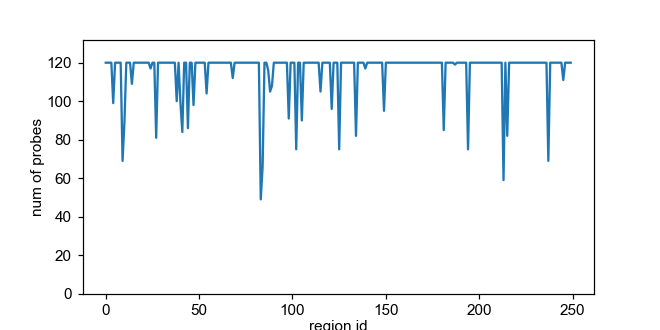

In [120]:
pb_num_dict = {_k:len(_v) for _k,_v in sub_library_250_1.items()}

pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"num of probes", labelpad=1)
plt.xlabel(f"region id", labelpad=1)
plt.ylim([0, num_probes_per_region*1.1])
plt.show()

## for 250_2 gene library, change primers from [2,9] into [16,15]


In [99]:
from ImageAnalysis3 import library_tools
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Primers'
primers_250_2 = library_tools.assemble.load_primers([16,15], _primer_folder=primer_folder)

- Picked primer: ID: W1B05_primer_16
Name: W1B05_primer_16
Description: W1B05_primer_16
Number of features: 0
Seq('CGGGTTTCGTTGCGCACACC')
- Picked primer: ID: W1B04_primer_15
Name: W1B04_primer_15
Description: W1B04_primer_15
Number of features: 0
Seq('TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA')


In [121]:
sub_library_250_2_records = []
for _reg, _pbs in sub_library_250_2.items():
    sub_library_250_2_records.extend(_pbs)

# replace primers
for _irecord, _record in enumerate(sub_library_250_2_records):
    _seq = primers_250_2[0].seq[-primer_len:] + _record.seq[primer_len:-primer_len] + primers_250_2[1].seq[-primer_len:].reverse_complement()
    _name = _record.name.split('primers_[')[0] + 'primers_['+primers_250_2[0].id +','+ primers_250_2[1].id+']' \
    + '_library_1000-mouse-genome_250_2'
    sub_library_250_2_records[_irecord] = SeqRecord(_seq, name=_name, id=_name, description='')
    
# quality check primers
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
primer_check = check._check_primer_usage(sub_library_250_2_records, primers_250_2[0], primers_250_2[1], primer_len=primer_len)
print(primer_check)

-- Checking primer usage, total probes: 27746
True


In [123]:
# save kept records
print(sub_library_250_2_records[0])
print(len(sub_library_250_2_records))
with open(os.path.join(library_folder, 'filtered_full_probes_sublibrary_250_2.fasta'), 'w') as output_handle:
    SeqIO.write(sub_library_250_2_records, output_handle, "fasta")

ID: loc_1:11240000-11260000_gene_4_pb_83_pos_7744_strand_+_readouts_[NDB_752_c,NDB_832_c,NDB_940_c]_primers_[W1B05_primer_16,W1B04_primer_15]_library_1000-mouse-genome_250_2
Name: loc_1:11240000-11260000_gene_4_pb_83_pos_7744_strand_+_readouts_[NDB_752_c,NDB_832_c,NDB_940_c]_primers_[W1B05_primer_16,W1B04_primer_15]_library_1000-mouse-genome_250_2
Number of features: 0
Seq('CGGGTTTCGTTGCGCACACCGATACACCCTGGACGCAAATTAAAATTAGCTGCC...AAG')
27746


<IPython.core.display.Javascript object>


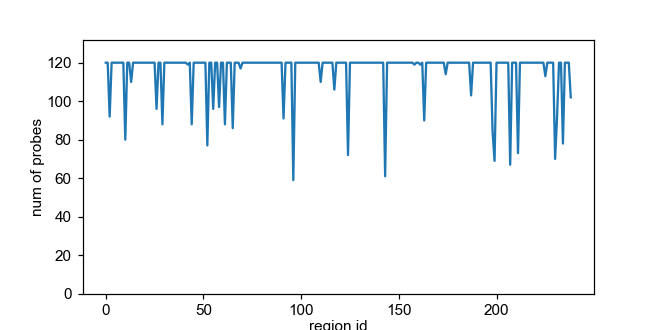

In [104]:
pb_num_dict = {_k:len(_v) for _k,_v in sub_library_250_2.items()}

pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"num of probes", labelpad=1)
plt.xlabel(f"region id", labelpad=1)
plt.ylim([0, num_probes_per_region*1.1])
plt.show()

# extract smaller set, ~60 probe

In [136]:
short_probe_num = 60

- Picked primer: ID: W1A11_primer_10
Name: W1A11_primer_10
Description: W1A11_primer_10
Number of features: 0
Seq('TTGCTAGCGTGGGCCAATCG')
- Picked primer: ID: W1B06_primer_17
Name: W1B06_primer_17
Description: W1B06_primer_17
Number of features: 0
Seq('TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA')
ID: loc_1:3740000-3760000_gene_1_pb_23_pos_2742_strand_-_readouts_[NDB_856_c,NDB_946_c,NDB_935_c]_primers_[W1A11_primer_10,W1B06_primer_17]_library_1000-mouse-genome-short_500
Name: loc_1:3740000-3760000_gene_1_pb_23_pos_2742_strand_-_readouts_[NDB_856_c,NDB_946_c,NDB_935_c]_primers_[W1A11_primer_10,W1B06_primer_17]_library_1000-mouse-genome-short_500
Number of features: 0
Seq('TTGCTAGCGTGGGCCAATCGTATACATTAGGATTGCGAGCTGTCATAACTGTGT...AGG')
29845


<IPython.core.display.Javascript object>


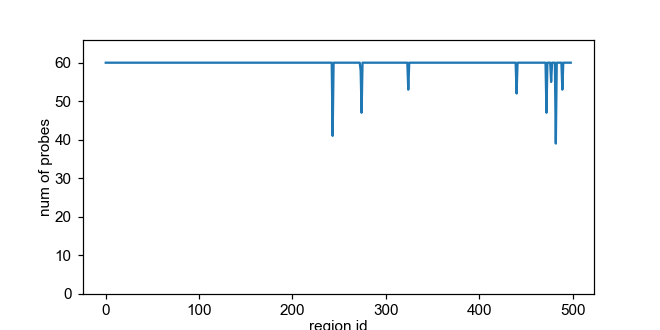

In [143]:
from ImageAnalysis3 import library_tools
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Primers'
primers_500_short = library_tools.assemble.load_primers([10,17], _primer_folder=primer_folder)

sub_library_500_short_records = []
for _reg, _pbs in sub_library_500.items():

    if len(_pbs) >= short_probe_num:
        _sel_num = short_probe_num
    else:
        _sel_num = len(_pbs)
        
    sub_library_500_short_records.extend(_pbs[:_sel_num])
    
# replace primers
for _irecord, _record in enumerate(sub_library_500_short_records):
    _seq = primers_500_short[0].seq[-primer_len:] \
        + _record.seq[primer_len:-primer_len] \
        + primers_500_short[1].seq[-primer_len:].reverse_complement()
    _name = _record.name.split('primers_[')[0] + 'primers_['+primers_500_short[0].id +','+ primers_500_short[1].id+']' \
    + '_library_1000-mouse-genome-short_500'
    sub_library_500_short_records[_irecord] = SeqRecord(_seq, name=_name, id=_name, description='')
    
# save kept records
print(sub_library_500_short_records[0])
print(len(sub_library_500_short_records))
with open(os.path.join(library_folder, 'filtered_full_probes_sublibrary_500_short.fasta'), 'w') as output_handle:
    SeqIO.write(sub_library_500_short_records, output_handle, "fasta")
    
    
pb_num_dict = {_k:len(_v) for _k,_v in library_tools.quality_check.split_probe_by_gene(sub_library_500_short_records).items()}

pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"num of probes", labelpad=1)
plt.xlabel(f"region id", labelpad=1)
plt.ylim([0, short_probe_num*1.1])
plt.show()

In [148]:
from ImageAnalysis3 import library_tools
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Primers'
primers_250_1_short = library_tools.assemble.load_primers([4,3], _primer_folder=primer_folder)

sub_library_250_1_short_records = []
for _reg, _pbs in sub_library_250_1.items():

    if len(_pbs) >= short_probe_num:
        _sel_num = short_probe_num
    else:
        _sel_num = len(_pbs)
        
    sub_library_250_1_short_records.extend(_pbs[:_sel_num])
    
# replace primers
for _irecord, _record in enumerate(sub_library_250_1_short_records):
    _seq = primers_250_1_short[0].seq[-primer_len:] \
        + _record.seq[primer_len:-primer_len] \
        + primers_250_1_short[1].seq[-primer_len:].reverse_complement()
    _name = _record.name.split('primers_[')[0] + 'primers_['+primers_250_1_short[0].id +','+ primers_250_1_short[1].id+']' \
    + '_library_1000-mouse-genome-short_250_1'
    sub_library_250_1_short_records[_irecord] = SeqRecord(_seq, name=_name, id=_name, description='')
    
# save kept records
print(sub_library_250_1_short_records[0])
print(len(sub_library_250_1_short_records))
with open(os.path.join(library_folder, 'filtered_full_probes_sublibrary_250_1_short.fasta'), 'w') as output_handle:
    SeqIO.write(sub_library_250_1_short_records, output_handle, "fasta")
    
pb_num_dict = {_k:len(_v) for _k,_v in library_tools.quality_check.split_probe_by_gene(sub_library_250_1_short_records).items()}

pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"num of probes", labelpad=1)
plt.xlabel(f"region id", labelpad=1)
plt.ylim([0, short_probe_num*1.1])
plt.show()

- Picked primer: ID: W1A05_primer_4
Name: W1A05_primer_4
Description: W1A05_primer_4
Number of features: 0
Seq('CATTCAGCATTGCGCAACGG')
- Picked primer: ID: W1A04_primer_3
Name: W1A04_primer_3
Description: W1A04_primer_3
Number of features: 0
Seq('TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC')
ID: loc_1:6240000-6260000_gene_2_pb_58_pos_5958_strand_-_readouts_[NDB_965_c,NDB_883_c,NDB_742_c]_primers_[W1A05_primer_4,W1A04_primer_3]_library_1000-mouse-genome-short_250_1
Name: loc_1:6240000-6260000_gene_2_pb_58_pos_5958_strand_-_readouts_[NDB_965_c,NDB_883_c,NDB_742_c]_primers_[W1A05_primer_4,W1A04_primer_3]_library_1000-mouse-genome-short_250_1
Number of features: 0
Seq('CATTCAGCATTGCGCAACGGCTTAGTCTCGCGCGCCGGATTTTCCCAGGGTGAG...CGC')
14988


<IPython.core.display.Javascript object>

- Picked primer: ID: W1A01_primer_0
Name: W1A01_primer_0
Description: W1A01_primer_0
Number of features: 0
Seq('CGGCTCGCAGCGTGTAAACG')
- Picked primer: ID: W1A02_primer_1
Name: W1A02_primer_1
Description: W1A02_primer_1
Number of features: 0
Seq('TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG')
ID: loc_1:11240000-11260000_gene_4_pb_83_pos_7744_strand_+_readouts_[NDB_752_c,NDB_832_c,NDB_940_c]_primers_[W1A01_primer_0,W1A02_primer_1]_library_1000-mouse-genome-short_250_2
Name: loc_1:11240000-11260000_gene_4_pb_83_pos_7744_strand_+_readouts_[NDB_752_c,NDB_832_c,NDB_940_c]_primers_[W1A01_primer_0,W1A02_primer_1]_library_1000-mouse-genome-short_250_2
Number of features: 0
Seq('CGGCTCGCAGCGTGTAAACGGATACACCCTGGACGCAAATTAAAATTAGCTGCC...ATG')
14339


<IPython.core.display.Javascript object>


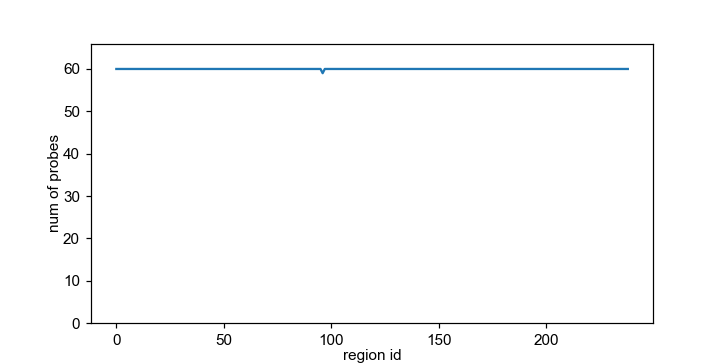

In [149]:
from ImageAnalysis3 import library_tools
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Primers'
primers_250_2_short = library_tools.assemble.load_primers([0,1], _primer_folder=primer_folder)

sub_library_250_2_short_records = []
for _reg, _pbs in sub_library_250_2.items():

    if len(_pbs) >= short_probe_num:
        _sel_num = short_probe_num
    else:
        _sel_num = len(_pbs)
        
    sub_library_250_2_short_records.extend(_pbs[:_sel_num])
    
# replace primers
for _irecord, _record in enumerate(sub_library_250_2_short_records):
    _seq = primers_250_2_short[0].seq[-primer_len:] \
        + _record.seq[primer_len:-primer_len] \
        + primers_250_2_short[1].seq[-primer_len:].reverse_complement()
    _name = _record.name.split('primers_[')[0] + 'primers_['+primers_250_2_short[0].id +','+ primers_250_2_short[1].id+']' \
    + '_library_1000-mouse-genome-short_250_2'
    sub_library_250_2_short_records[_irecord] = SeqRecord(_seq, name=_name, id=_name, description='')
    
# save kept records
print(sub_library_250_2_short_records[0])
print(len(sub_library_250_2_short_records))
with open(os.path.join(library_folder, 'filtered_full_probes_sublibrary_250_2_short.fasta'), 'w') as output_handle:
    SeqIO.write(sub_library_250_2_short_records, output_handle, "fasta")
    
pb_num_dict = {_k:len(_v) for _k,_v in library_tools.quality_check.split_probe_by_gene(sub_library_250_2_short_records).items()}

pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"num of probes", labelpad=1)
plt.xlabel(f"region id", labelpad=1)
plt.ylim([0, short_probe_num*1.1])
plt.show()

<IPython.core.display.Javascript object>


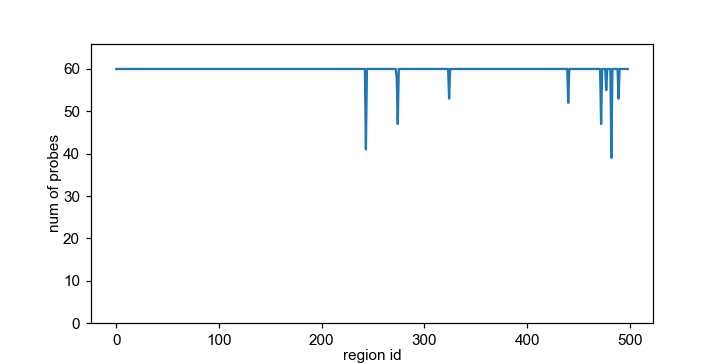

In [153]:
# MERGE these 6 libraries into one file:

final_probe_files = [os.path.join(library_folder, _fl) for _fl in os.listdir(library_folder)
                     if 'filtered_full_probes_sublibrary' in _fl]
print('\n'.join(final_probe_files))

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\filtered_full_probes_sublibrary_500.fasta
\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\filtered_full_probes_sublibrary_250_1.fasta
\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\filtered_full_probes_sublibrary_250_2.fasta
\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\filtered_full_probes_sublibrary_500_short.fasta
\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\filtered_full_probes_sublibrary_250_1_short.fasta
\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\mouse_genome_1000\filtered_full_probes_sublibrary_250_2_short.fasta


In [156]:
pool_records = []

for _fl in final_probe_files:
    with open(_fl, 'r') as handle:
        for record in SeqIO.parse(handle, "fasta"):
            pool_records.append(record)
            
print(len(pool_records))

173891


In [162]:
# primer statistics
primer_set_count = {}

for _record in pool_records:
    _primer_info = _record.id.split('primers_[')[1].split(']')[0]
    if _primer_info not in primer_set_count:
        primer_set_count[_primer_info] = 1
    else:
        primer_set_count[_primer_info] += 1
    


In [163]:
primer_set_count

{'W1A03_primer_2,W1A10_primer_9': 57936,
 'W1A07_primer_6,W1A12_primer_11': 29037,
 'W1B05_primer_16,W1B04_primer_15': 27746,
 'W1A11_primer_10,W1B06_primer_17': 29845,
 'W1A05_primer_4,W1A04_primer_3': 14988,
 'W1A01_primer_0,W1A02_primer_1': 14339}

In [164]:
# save kept records
with open(os.path.join(pool_folder, 'final_pool_probes.fasta'), 'w') as output_handle:
    print(len(pool_records))
    SeqIO.write(pool_records, output_handle, "fasta")

173891


In [5]:
## Generate primer usage information
# load full probes
final_pool_filename = os.path.join(pool_folder, 'final_pool_probes.fasta')
pool_records = []
with open(os.path.join(library_folder, final_pool_filename), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        pool_records.append(record)

In [17]:
sublibrary_probe_dict = {}
for _record in pool_records:
    _lib = _record.name.split('library_')[-1]
    if _lib not in sublibrary_probe_dict:
        sublibrary_probe_dict[_lib] = [_record]
    else:
        sublibrary_probe_dict[_lib].append(_record)

In [18]:
for _lib, _pbs in sublibrary_probe_dict.items():
    print(_lib, len(_pbs))

1000-mouse-genome_500 57936
1000-mouse-genome_250_1 29037
1000-mouse-genome_250_2 27746
1000-mouse-genome-short_500 29845
1000-mouse-genome-short_250_1 14988
1000-mouse-genome-short_250_2 14339


In [16]:
pool_records[0].id

'loc_1:3740000-3760000_gene_1_pb_23_pos_2742_strand_-_readouts_[NDB_856_c,NDB_946_c,NDB_935_c]_primers_[W1A03_primer_2,W1A10_primer_9]_library_1000-mouse-genome_500_library_1000-mouse-genome_500'

In [32]:
# 1000-mouse-genome_250_1
vol = 11 * 1e3 # ul
conc = 130 * 1e-9 # g/ul
num_pb = 29037
pb_len = 142-11
final_conc = 10 # nM
pb_mw = (pb_len * 303.7 + 79) # g/mol

mass_total = vol * conc
mass_per_pb = mass_total / num_pb
mol_per_pb = mass_per_pb / pb_mw
print(mass_total)
print(mass_per_pb)
print(mol_per_pb)
target_conc = final_conc * 1e-9 * 1e-6 # mol/ul
final_vol = mol_per_pb / target_conc
print("final in ul:", final_vol)

0.00143
4.924751179529566e-08
1.23539741156229e-12
final in ul: 123.53974115622901


In [33]:
# 1000-mouse-genome_250_2
vol = 11 * 1e3 # ul
conc = 125 * 1e-9 # g/ul
num_pb = 27746
pb_len = 142-11
final_conc = 10 # nM
pb_mw = (pb_len * 303.7 + 79) # g/mol

mass_total = vol * conc
mass_per_pb = mass_total / num_pb
mol_per_pb = mass_per_pb / pb_mw
print(mass_total)
print(mass_per_pb)
print(mol_per_pb)
target_conc = final_conc * 1e-9 * 1e-6 # mol/ul
final_vol = mol_per_pb / target_conc
print("final in ul:", final_vol)

0.0013750000000000001
4.955669285662799e-08
1.2431533665120898e-12
final in ul: 124.31533665120898


In [34]:
# 1000-mouse-genome_500_1
vol = 11 * 1e3 # ul
conc = 116 * 1e-9 # g/ul
num_pb = 57936
pb_len = 142-11
final_conc = 10 # nM
pb_mw = (pb_len * 303.7 + 79) # g/mol

mass_total = vol * conc
mass_per_pb = mass_total / num_pb
mol_per_pb = mass_per_pb / pb_mw
print(mass_total)
print(mass_per_pb)
print(mol_per_pb)
target_conc = final_conc * 1e-9 * 1e-6 # mol/ul
final_vol = mol_per_pb / target_conc
print("final in ul:", final_vol)

0.001276
2.2024302678818007e-08
5.524901772494276e-13
final in ul: 55.24901772494276


In [35]:
# 1000-mouse-genome_500_1
vol = 11 * 1e3 # ul
conc = 130 * 1e-9 # g/ul
num_pb = 57936
pb_len = 142-11
final_conc = 10 # nM
pb_mw = (pb_len * 303.7 + 79) # g/mol

mass_total = vol * conc
mass_per_pb = mass_total / num_pb
mol_per_pb = mass_per_pb / pb_mw
print(mass_total)
print(mass_per_pb)
print(mol_per_pb)
target_conc = final_conc * 1e-9 * 1e-6 # mol/ul
final_vol = mol_per_pb / target_conc
print("final in ul:", final_vol)

0.00143
2.4682408174537422e-08
6.191700262278068e-13
final in ul: 61.917002622780686
